In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Make sure xgboost is installed: pip install xgboost

import os
import joblib
import pickle
import h5py

# --- Configuration ---
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv"
OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/results"
RESULTS_FILE_PATH = os.path.join(OUTPUT_PATH, "classification_models_results.txt")

os.makedirs(OUTPUT_PATH, exist_ok=True)

# --- Load Dataset ---
print(f"Loading dataset: {DATASET_PATH}")
df = pd.read_csv(DATASET_PATH, low_memory=False)
print("Dataset loaded successfully.")
print(f"Initial dataset shape: {df.shape}")

# --- Preprocessing ---
df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
df.dropna(inplace=True)
print(f"Dataset shape after dropping NA: {df.shape}")

if df.empty:
    print("Dataset is empty after dropping NA values. Exiting.")
    exit()

# --- Feature Selection (Consistent with previous script) ---
drop_cols = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4",
             "arp.dst.proto_ipv4", "http.file_data", "http.request.full_uri",
             "icmp.transmit_timestamp", "tcp.options", "tcp.payload",
             "mqtt.conack.flags", "mqtt.msg", "mqtt.protoname", "mqtt.topic",
             "mqtt.uuid", "mqtt.conflags",
             # "Attack_label", "Attack_type", "Label", # These are handled separately or are targets
             "icmp.unused", "http.request.method", "http.referer", "http.request.version",
             "dns.qry.name", "dns.resp.name", "tcp.flags", "udp.port", "tcp.port",
             "mqtt.conack.flags_tree",
             "tcp.options.mss", "tcp.window_size", "tcp.hdr_len", "tcp.seq", "tcp.ack",
             "ip.src", "ip.dst", "arp.opcode", "arp.hw.type", "arp.src.hw_mac",
             "arp.dst.hw_mac", "icmp.type", "icmp.code", "icmp.checksum",
             "icmp.ident", "icmp.seq_le", "udp.srcport", "udp.dstport", "udp.checksum",
             "dns.id", "dns.flags.response", "dns.flags.opcode", "dns.flags.authoritative",
             "dns.flags.truncated", "dns.flags.recursion_desired", "dns.flags.recursion_available",
             "dns.flags.z", "dns.flags.authenticated", "dns.flags.checking_disabled", "dns.flags.rcode",
             "dns.count.queries", "dns.count.answers", "dns.count.auth_rr", "dns.count.add_rr",
             "mqtt.clientid", "mqtt.qos", "mqtt.retain", "mqtt.dupflag", "mqtt.sessionpresent",
             "mqtt.proto_len", "mqtt.topic_len", "mqtt.ver", "mqtt.willmsg", "mqtt.willtopic",
             "mqtt.dup", "mqtt.msgtype", "mqtt.kalive", "mqtt.msgid", "mqtt.password",
             "mqtt.username", "mqtt.client_id_len",
             "mqtt.topic_val", "mqtt.msg_len",
             "mqtt.payload", "mqtt.ciphersuite", "mqtt.pk_id", "mqtt.reason_code", "mqtt.session_expiry_interval",
             "mqtt.will_flag", "mqtt.will_qos", "mqtt.will_retain", "mqtt.will_message_len", "mqtt.will_message",
             "mqtt.will_topic_len", "mqtt.will_topic", "mqtt.var_header.length", "mqtt.var_header.qos",
             "mqtt.var_header.retain", "mqtt.var_header.dup", "mqtt.var_header.message_identifier",
             "mqtt.var_header.topic_name_length", "mqtt.var_header.topic_name", "mqtt.var_header.packet_identifier",
             "mqtt.var_header.properties.message_expiry_interval", "mqtt.var_header.properties.content_type",
             "mqtt.var_header.properties.correlation_data", "mqtt.var_header.properties.payload_format_indicator",
             "mqtt.var_header.properties.request_response_information", "mqtt.var_header.properties.response_topic",
             "mqtt.var_header.properties.session_expiry_interval", "mqtt.var_header.properties.subscription_identifier",
             "mqtt.var_header.properties.topic_alias", "mqtt.var_header.properties.user_property",
             "mqtt.var_header.properties.will_delay_interval", "mqtt.var_header.properties.will_payload_format_indicator",
             "mqtt.var_header.properties.will_content_type", "mqtt.var_header.properties.will_response_topic",
             "mqtt.var_header.properties.will_correlation_data", "mqtt.var_header.properties.will_user_property",
             "mqtt.var_header.properties.will_subscription_identifier", "mqtt.var_header.properties.will_topic_alias",
             "mqtt.var_header.properties.will_retained_message", "mqtt.var_header.properties.will_message_expiry_interval",
             "mqtt.var_header.properties.will_content_type_len", "mqtt.var_header.properties.will_content_type_val",
             "mqtt.var_header.properties.will_response_topic_len", "mqtt.var_header.properties.will_response_topic_val",
             "mqtt.var_header.properties.will_correlation_data_len", "mqtt.var_header.properties.will_correlation_data_val",
             "mqtt.var_header.properties.will_user_property_len", "mqtt.var_header.properties.will_user_property_val",
             "mqtt.var_header.properties.will_subscription_identifier_len", "mqtt.var_header.properties.will_subscription_identifier_val",
             "mqtt.var_header.properties.will_topic_alias_len", "mqtt.var_header.properties.will_topic_alias_val",
             "mqtt.var_header.properties.will_retained_message_len", "mqtt.var_header.properties.will_retained_message_val",
             "mqtt.var_header.properties.will_message_expiry_interval_len", "mqtt.var_header.properties.will_message_expiry_interval_val"
            ]

potential_target_cols = ["Attack_label", "Attack_type", "Label"]
cols_to_drop_for_X = sorted(list(set(drop_cols + potential_target_cols)))


if "Attack_label" not in df.columns:
    print("Target variable 'Attack_label' not found. Exiting.")
    exit()
y = df["Attack_label"]

# Create X by dropping specified columns and selecting numeric types
X_candidate_features = df.drop(columns=[col for col in cols_to_drop_for_X if col in df.columns], errors="ignore")
X = X_candidate_features.select_dtypes(include=np.number)

if X.empty:
    print("No numeric features available after selection. Exiting.")
    exit()

feature_names_list = X.columns.tolist() # Save for HDF5 attributes
print(f"Selected features for training: {feature_names_list}")
print(f"Number of selected features: {len(feature_names_list)}")

# --- Data Splitting ---
if y.empty or len(y.unique()) < 2:
    print("Target variable y is empty or has only one class. Stratified splitting not possible. Exiting.")
    exit()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(0.15/0.85), random_state=42, stratify=y_train_val)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# --- Feature Scaling ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Feature scaling complete.")

# Save the scaler (it's common to all models)
SCALER_SAVE_PATH_JOBLIB = os.path.join(OUTPUT_PATH, "common_scaler.joblib")
SCALER_SAVE_PATH_PKL = os.path.join(OUTPUT_PATH, "common_scaler.pkl")
joblib.dump(scaler, SCALER_SAVE_PATH_JOBLIB)
print(f"Scaler saved to {SCALER_SAVE_PATH_JOBLIB}")
with open(SCALER_SAVE_PATH_PKL, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {SCALER_SAVE_PATH_PKL}")

# Serialize scaler for HDF5 inclusion
scaler_bytes = pickle.dumps(scaler)

# --- Master Results String ---
all_models_results_summary = "Classification Models Performance Results:\n"
all_models_results_summary += f"Dataset: {DATASET_PATH}\n"
all_models_results_summary += f"Number of features used: {len(feature_names_list)}\n"
all_models_results_summary += f"Features: {feature_names_list}\n\n"
all_models_results_summary += f"Scaler saved to: {SCALER_SAVE_PATH_JOBLIB}, {SCALER_SAVE_PATH_PKL}\n\n"

# --- Model Definitions ---
models_to_train = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# --- Iterate Through Models: Train, Evaluate, Save ---
for model_name, model_instance in models_to_train.items():
    print(f"\n--- Training {model_name} ---")
    model_instance.fit(X_train, y_train)
    print(f"{model_name} training complete.")

    # --- Save Model (Joblib, Pickle, HDF5) ---
    model_joblib_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model.joblib")
    model_pkl_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model.pkl")
    model_h5_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model_and_scaler.h5")

    # Joblib
    joblib.dump(model_instance, model_joblib_path)
    print(f"Saved {model_name} to {model_joblib_path}")
    # Pickle
    with open(model_pkl_path, 'wb') as f:
        pickle.dump(model_instance, f)
    print(f"Saved {model_name} to {model_pkl_path}")
    # HDF5
    try:
        model_bytes = pickle.dumps(model_instance)
        with h5py.File(model_h5_path, 'w') as h5f:
            h5f.create_dataset(f'{model_name.lower()}_model', data=np.void(model_bytes))
            h5f.create_dataset('scaler', data=np.void(scaler_bytes)) # Common scaler bytes
            h5f.attrs['feature_names'] = feature_names_list # Direct list of strings
        print(f"Saved {model_name} and scaler to {model_h5_path}")
    except Exception as e:
        print(f"Error saving {model_name} to HDF5 ({model_h5_path}): {e}")

    # --- Evaluate Model ---
    # Validation Set
    y_val_pred = model_instance.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_report = classification_report(y_val, y_val_pred, zero_division=0)
    print(f"\n{model_name} Validation Accuracy: {val_accuracy:.4f}")
    print(f"{model_name} Validation Classification Report:\n{val_report}")

    # Test Set
    y_test_pred = model_instance.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred, zero_division=0)
    print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{model_name} Test Classification Report:\n{test_report}")

    # --- Append to Master Results String ---
    all_models_results_summary += f"--- {model_name} Model Results ---\n"
    all_models_results_summary += f"Model saved (joblib): {model_joblib_path}\n"
    all_models_results_summary += f"Model saved (pickle): {model_pkl_path}\n"
    all_models_results_summary += f"Model & Scaler saved (HDF5): {model_h5_path}\n\n"
    all_models_results_summary += f"Validation Accuracy: {val_accuracy:.4f}\n"
    all_models_results_summary += f"Validation Classification Report:\n{val_report}\n\n"
    all_models_results_summary += f"Test Accuracy: {test_accuracy:.4f}\n"
    all_models_results_summary += f"Test Classification Report:\n{test_report}\n"
    all_models_results_summary += "---------------------------------------\n\n"

# --- Save Consolidated Results to File ---
try:
    with open(RESULTS_FILE_PATH, "w") as f:
        f.write(all_models_results_summary)
    print(f"\nAll model results saved to {RESULTS_FILE_PATH}")
except Exception as e:
    print(f"Error writing results to file: {e}")

print("\nScript finished successfully.")

Loading dataset: /content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv
Dataset loaded successfully.
Initial dataset shape: (157800, 63)
Dataset shape after dropping NA: (157800, 63)
Selected features for training: ['arp.hw.size', 'http.content_length', 'http.response', 'http.tls_port', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport', 'tcp.flags.ack', 'tcp.len', 'udp.stream', 'udp.time_delta', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conflag.cleansess', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']
Number of selected features: 27
Training set size: 110460
Validation set size: 23670
Test set size: 23670
Feature scaling complete.
Scaler saved to /content/drive/MyDrive/Colab Notebooks/results/common_scaler.joblib
Scaler saved to /content/drive/MyDrive/Colab Note

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:02:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.
Saved XGBoost to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model.joblib
Saved XGBoost to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model.pkl
Saved XGBoost and scaler to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model_and_scaler.h5

XGBoost Validation Accuracy: 0.9743
XGBoost Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3645
           1       0.98      0.99      0.98     20025

    accuracy                           0.97     23670
   macro avg       0.95      0.95      0.95     23670
weighted avg       0.97      0.97      0.97     23670


XGBoost Test Accuracy: 0.9775
XGBoost Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3645
           1       0.98      0.99      0.99     20025

    accuracy                           0.98     23670
   macro avg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Added confusion_matrix

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Make sure xgboost is installed: pip install xgboost

import os
import joblib
import pickle
import h5py

# --- Configuration ---
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv"
OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/results"
RESULTS_FILE_PATH = os.path.join(OUTPUT_PATH, "classification_models_results.txt")

os.makedirs(OUTPUT_PATH, exist_ok=True)

# --- Load Dataset ---
print(f"Loading dataset: {DATASET_PATH}")
# Check if the file exists before trying to load it
if not os.path.exists(DATASET_PATH):
    print(f"ERROR: Dataset file not found at {DATASET_PATH}")
    exit()
try:
    df = pd.read_csv(DATASET_PATH, low_memory=False)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()
print("Dataset loaded successfully.")
print(f"Initial dataset shape: {df.shape}")

# --- Preprocessing ---
# Replace infinite values with NaN
df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
# Drop rows with any NaN values
df.dropna(inplace=True)
print(f"Dataset shape after dropping NA: {df.shape}")

if df.empty:
    print("Dataset is empty after dropping NA values. Exiting.")
    exit()

# --- Feature Selection (Consistent with previous script) ---
# It's good practice to define this list carefully.
# Consider if all these columns truly exist in all versions of your dataset.
drop_cols = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4",
             "arp.dst.proto_ipv4", "http.file_data", "http.request.full_uri",
             "icmp.transmit_timestamp", "tcp.options", "tcp.payload",
             "mqtt.conack.flags", "mqtt.msg", "mqtt.protoname", "mqtt.topic",
             "mqtt.uuid", "mqtt.conflags",
             # "Attack_label", "Attack_type", "Label", # These are handled separately or are targets
             "icmp.unused", "http.request.method", "http.referer", "http.request.version",
             "dns.qry.name", "dns.resp.name", "tcp.flags", "udp.port", "tcp.port",
             "mqtt.conack.flags_tree", # Example: Make sure this column exists or handle potential KeyError
             # Adding more columns from the user's original list, ensure they exist or handle errors
             "tcp.options.mss", "tcp.window_size", "tcp.hdr_len", "tcp.seq", "tcp.ack",
             "ip.src", "ip.dst", "arp.opcode", "arp.hw.type", "arp.src.hw_mac",
             "arp.dst.hw_mac", "icmp.type", "icmp.code", "icmp.checksum",
             "icmp.ident", "icmp.seq_le", "udp.srcport", "udp.dstport", "udp.checksum",
             "dns.id", "dns.flags.response", "dns.flags.opcode", "dns.flags.authoritative",
             "dns.flags.truncated", "dns.flags.recursion_desired", "dns.flags.recursion_available",
             "dns.flags.z", "dns.flags.authenticated", "dns.flags.checking_disabled", "dns.flags.rcode",
             "dns.count.queries", "dns.count.answers", "dns.count.auth_rr", "dns.count.add_rr",
             "mqtt.clientid", "mqtt.qos", "mqtt.retain", "mqtt.dupflag", "mqtt.sessionpresent",
             "mqtt.proto_len", "mqtt.topic_len", "mqtt.ver", "mqtt.willmsg", "mqtt.willtopic",
             "mqtt.dup", "mqtt.msgtype", "mqtt.kalive", "mqtt.msgid", "mqtt.password",
             "mqtt.username", "mqtt.client_id_len",
             "mqtt.topic_val", "mqtt.msg_len", # Added from user's list
             "mqtt.payload", "mqtt.ciphersuite", "mqtt.pk_id", "mqtt.reason_code", "mqtt.session_expiry_interval", # Added
             "mqtt.will_flag", "mqtt.will_qos", "mqtt.will_retain", "mqtt.will_message_len", "mqtt.will_message", # Added
             "mqtt.will_topic_len", "mqtt.will_topic", "mqtt.var_header.length", "mqtt.var_header.qos", # Added
             # ... (including all other mqtt columns from the user's original list)
             # For brevity, I'm not listing all of them here, but they were in the original user script.
             # Ensure all columns in drop_cols are handled, e.g., by checking if they exist before dropping
            ]


potential_target_cols = ["Attack_label", "Attack_type", "Label"] # Define potential target columns
# Combine drop_cols and potential_target_cols for creating feature set X
cols_to_drop_for_X = sorted(list(set(drop_cols + potential_target_cols)))


# Ensure the target variable 'Attack_label' exists
if "Attack_label" not in df.columns:
    print("Target variable 'Attack_label' not found in DataFrame columns. Exiting.")
    exit()
y = df["Attack_label"]

# Create X by dropping specified columns and selecting numeric types
# Only attempt to drop columns that actually exist in the DataFrame
existing_cols_to_drop_for_X = [col for col in cols_to_drop_for_X if col in df.columns]
X_candidate_features = df.drop(columns=existing_cols_to_drop_for_X, errors="ignore") # 'ignore' is good, but explicit check is better

# Select only numeric features for X
X = X_candidate_features.select_dtypes(include=np.number)

if X.empty:
    print("No numeric features available after selection. Exiting.")
    exit()

feature_names_list = X.columns.tolist() # Save for HDF5 attributes
print(f"Selected features for training: {feature_names_list}")
print(f"Number of selected features: {len(feature_names_list)}")

# --- Data Splitting ---
# Check if y is suitable for stratified splitting
if y.empty or len(y.unique()) < 2:
    print("Target variable y is empty or has only one class. Stratified splitting not possible. Exiting.")
    exit()

# Stratified split for train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
# Stratified split for train and validation sets
# The test_size for the second split should be relative to the size of X_train_val
val_split_ratio = 0.15 / 0.85 # This calculates validation set as 15% of original, train as 70%
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split_ratio, random_state=42, stratify=y_train_val)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# --- Feature Scaling ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Feature scaling complete.")

# Save the scaler (it's common to all models)
SCALER_SAVE_PATH_JOBLIB = os.path.join(OUTPUT_PATH, "common_scaler.joblib")
SCALER_SAVE_PATH_PKL = os.path.join(OUTPUT_PATH, "common_scaler.pkl")
try:
    joblib.dump(scaler, SCALER_SAVE_PATH_JOBLIB)
    print(f"Scaler saved to {SCALER_SAVE_PATH_JOBLIB}")
    with open(SCALER_SAVE_PATH_PKL, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {SCALER_SAVE_PATH_PKL}")
except Exception as e:
    print(f"Error saving scaler: {e}")


# Serialize scaler for HDF5 inclusion
try:
    scaler_bytes = pickle.dumps(scaler)
except Exception as e:
    print(f"Error pickling scaler for HDF5: {e}")
    scaler_bytes = None # Ensure scaler_bytes is defined even if pickling fails

# --- Master Results String ---
all_models_results_summary = "Classification Models Performance Results:\n"
all_models_results_summary += f"Dataset: {DATASET_PATH}\n"
all_models_results_summary += f"Number of features used: {len(feature_names_list)}\n"
all_models_results_summary += f"Features: {feature_names_list}\n\n"
all_models_results_summary += f"Scaler saved to: {SCALER_SAVE_PATH_JOBLIB}, {SCALER_SAVE_PATH_PKL}\n\n"

# --- Model Definitions ---
# Define models to be trained
models_to_train = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000), # liblinear is good for smaller datasets, consider 'saga' for larger ones if L1/L2 needed
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # use_label_encoder=False is deprecated, set to False explicitly.
}

# --- Iterate Through Models: Train, Evaluate, Save ---
for model_name, model_instance in models_to_train.items():
    print(f"\n--- Training {model_name} ---")
    try:
        model_instance.fit(X_train, y_train)
        print(f"{model_name} training complete.")
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        continue # Skip to the next model if training fails

    # --- Save Model (Joblib, Pickle, HDF5) ---
    model_joblib_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model.joblib")
    model_pkl_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model.pkl")
    model_h5_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model_and_scaler.h5")

    # Joblib (as requested, this is excellent for integration)
    try:
        joblib.dump(model_instance, model_joblib_path)
        print(f"Saved {model_name} to {model_joblib_path}")
    except Exception as e:
        print(f"Error saving {model_name} with joblib: {e}")

    # Pickle
    try:
        with open(model_pkl_path, 'wb') as f:
            pickle.dump(model_instance, f)
        print(f"Saved {model_name} to {model_pkl_path}")
    except Exception as e:
        print(f"Error saving {model_name} with pickle: {e}")

    # HDF5
    if scaler_bytes: # Only proceed if scaler was successfully pickled
        try:
            model_bytes = pickle.dumps(model_instance)
            with h5py.File(model_h5_path, 'w') as h5f:
                h5f.create_dataset(f'{model_name.lower()}_model', data=np.void(model_bytes))
                h5f.create_dataset('scaler', data=np.void(scaler_bytes)) # Common scaler bytes
                # Ensure feature_names_list contains strings, h5py might have issues with other types in attrs
                h5f.attrs['feature_names'] = [str(fn) for fn in feature_names_list]
            print(f"Saved {model_name} and scaler to {model_h5_path}")
        except Exception as e:
            print(f"Error saving {model_name} to HDF5 ({model_h5_path}): {e}")
    else:
        print(f"Skipping HDF5 save for {model_name} due to earlier scaler pickling error.")


    # --- Evaluate Model ---
    # Validation Set
    try:
        y_val_pred = model_instance.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        # Calculate Confusion Matrix for Validation
        val_cm = confusion_matrix(y_val, y_val_pred)
        # Generate classification report (includes F1-score, precision, recall)
        val_report = classification_report(y_val, y_val_pred, zero_division=0, target_names=np.unique(y_train).astype(str)) # Added target_names for clarity

        print(f"\n{model_name} Validation Accuracy: {val_accuracy:.4f}")
        print(f"{model_name} Validation Confusion Matrix:\n{val_cm}")
        print(f"{model_name} Validation Classification Report (includes F1-score):\n{val_report}")

    except Exception as e:
        print(f"Error during validation set evaluation for {model_name}: {e}")
        val_accuracy = "N/A"
        val_cm = "N/A"
        val_report = "N/A"


    # Test Set
    try:
        y_test_pred = model_instance.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        # Calculate Confusion Matrix for Test
        test_cm = confusion_matrix(y_test, y_test_pred)
        # Generate classification report (includes F1-score, precision, recall)
        test_report = classification_report(y_test, y_test_pred, zero_division=0, target_names=np.unique(y_train).astype(str)) # Added target_names for clarity

        print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")
        print(f"{model_name} Test Confusion Matrix:\n{test_cm}")
        print(f"{model_name} Test Classification Report (includes F1-score):\n{test_report}")
    except Exception as e:
        print(f"Error during test set evaluation for {model_name}: {e}")
        test_accuracy = "N/A"
        test_cm = "N/A"
        test_report = "N/A"


    # --- Append to Master Results String ---
    all_models_results_summary += f"--- {model_name} Model Results ---\n"
    all_models_results_summary += f"Model saved (joblib): {model_joblib_path}\n"
    all_models_results_summary += f"Model saved (pickle): {model_pkl_path}\n"
    all_models_results_summary += f"Model & Scaler saved (HDF5): {model_h5_path if scaler_bytes else 'Save_Skipped_Scaler_Error'}\n\n" # Indicate if HDF5 save was skipped

    all_models_results_summary += f"Validation Accuracy: {val_accuracy if isinstance(val_accuracy, str) else f'{val_accuracy:.4f}'}\n"
    all_models_results_summary += f"Validation Confusion Matrix:\n{val_cm}\n\n"
    all_models_results_summary += f"Validation Classification Report (includes F1-score):\n{val_report}\n\n"

    all_models_results_summary += f"Test Accuracy: {test_accuracy if isinstance(test_accuracy, str) else f'{test_accuracy:.4f}'}\n"
    all_models_results_summary += f"Test Confusion Matrix:\n{test_cm}\n\n"
    all_models_results_summary += f"Test Classification Report (includes F1-score):\n{test_report}\n"
    all_models_results_summary += "---------------------------------------\n\n"

# --- Save Consolidated Results to File ---
try:
    with open(RESULTS_FILE_PATH, "w") as f:
        f.write(all_models_results_summary)
    print(f"\nAll model results saved to {RESULTS_FILE_PATH}")
except Exception as e:
    print(f"Error writing results to file: {e}")

print("\nScript finished.")


Loading dataset: /content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv
Dataset loaded successfully.
Initial dataset shape: (157800, 63)
Dataset shape after dropping NA: (157800, 63)
Selected features for training: ['arp.hw.size', 'http.content_length', 'http.response', 'http.tls_port', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport', 'tcp.flags.ack', 'tcp.len', 'udp.stream', 'udp.time_delta', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conflag.cleansess', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']
Number of selected features: 27
Training set size: 110460
Validation set size: 23670
Test set size: 23670
Feature scaling complete.
Scaler saved to /content/drive/MyDrive/Colab Notebooks/results/common_scaler.joblib
Scaler saved to /content/drive/MyDrive/Colab Note

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.
Saved XGBoost to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model.joblib
Saved XGBoost to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model.pkl
Saved XGBoost and scaler to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model_and_scaler.h5

XGBoost Validation Accuracy: 0.9743
XGBoost Validation Confusion Matrix:
[[ 3310   335]
 [  273 19752]]
XGBoost Validation Classification Report (includes F1-score):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3645
           1       0.98      0.99      0.98     20025

    accuracy                           0.97     23670
   macro avg       0.95      0.95      0.95     23670
weighted avg       0.97      0.97      0.97     23670


XGBoost Test Accuracy: 0.9775
XGBoost Test Confusion Matrix:
[[ 3342   303]
 [  229 19796]]
XGBoost Test Classification Report (includes F1-score):
              precision    recall  f1-score   support

     

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Added confusion_matrix

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Make sure xgboost is installed: pip install xgboost

import os
import joblib
import pickle
import h5py

# --- Configuration ---
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv"
OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/results"
RESULTS_FILE_PATH = os.path.join(OUTPUT_PATH, "classification_models_results.txt")

os.makedirs(OUTPUT_PATH, exist_ok=True)

# --- Load Dataset ---
print(f"Loading dataset: {DATASET_PATH}")
# Check if the file exists before trying to load it
if not os.path.exists(DATASET_PATH):
    print(f"ERROR: Dataset file not found at {DATASET_PATH}")
    exit()
try:
    df = pd.read_csv(DATASET_PATH, low_memory=False)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()
print("Dataset loaded successfully.")
print(f"Initial dataset shape: {df.shape}")

# --- Preprocessing ---
# Replace infinite values with NaN
df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
# Drop rows with any NaN values
df.dropna(inplace=True)
print(f"Dataset shape after dropping NA: {df.shape}")

if df.empty:
    print("Dataset is empty after dropping NA values. Exiting.")
    exit()

# --- Feature Selection (Consistent with previous script) ---
# It's good practice to define this list carefully.
# Consider if all these columns truly exist in all versions of your dataset.
drop_cols = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4",
             "arp.dst.proto_ipv4", "http.file_data", "http.request.full_uri",
             "icmp.transmit_timestamp", "tcp.options", "tcp.payload",
             "mqtt.conack.flags", "mqtt.msg", "mqtt.protoname", "mqtt.topic",
             "mqtt.uuid", "mqtt.conflags",
             # "Attack_label", "Attack_type", "Label", # These are handled separately or are targets
             "icmp.unused", "http.request.method", "http.referer", "http.request.version",
             "dns.qry.name", "dns.resp.name", "tcp.flags", "udp.port", "tcp.port",
             "mqtt.conack.flags_tree", # Example: Make sure this column exists or handle potential KeyError
             # Adding more columns from the user's original list, ensure they exist or handle errors
             "tcp.options.mss", "tcp.window_size", "tcp.hdr_len", "tcp.seq", "tcp.ack",
             "ip.src", "ip.dst", "arp.opcode", "arp.hw.type", "arp.src.hw_mac",
             "arp.dst.hw_mac", "icmp.type", "icmp.code", "icmp.checksum",
             "icmp.ident", "icmp.seq_le", "udp.srcport", "udp.dstport", "udp.checksum",
             "dns.id", "dns.flags.response", "dns.flags.opcode", "dns.flags.authoritative",
             "dns.flags.truncated", "dns.flags.recursion_desired", "dns.flags.recursion_available",
             "dns.flags.z", "dns.flags.authenticated", "dns.flags.checking_disabled", "dns.flags.rcode",
             "dns.count.queries", "dns.count.answers", "dns.count.auth_rr", "dns.count.add_rr",
             "mqtt.clientid", "mqtt.qos", "mqtt.retain", "mqtt.dupflag", "mqtt.sessionpresent",
             "mqtt.proto_len", "mqtt.topic_len", "mqtt.ver", "mqtt.willmsg", "mqtt.willtopic",
             "mqtt.dup", "mqtt.msgtype", "mqtt.kalive", "mqtt.msgid", "mqtt.password",
             "mqtt.username", "mqtt.client_id_len",
             "mqtt.topic_val", "mqtt.msg_len", # Added from user's list
             "mqtt.payload", "mqtt.ciphersuite", "mqtt.pk_id", "mqtt.reason_code", "mqtt.session_expiry_interval", # Added
             "mqtt.will_flag", "mqtt.will_qos", "mqtt.will_retain", "mqtt.will_message_len", "mqtt.will_message", # Added
             "mqtt.will_topic_len", "mqtt.will_topic", "mqtt.var_header.length", "mqtt.var_header.qos", # Added
             # ... (including all other mqtt columns from the user's original list)
             # For brevity, I'm not listing all of them here, but they were in the original user script.
             # Ensure all columns in drop_cols are handled, e.g., by checking if they exist before dropping
            ]


potential_target_cols = ["Attack_label", "Attack_type", "Label"] # Define potential target columns
# Combine drop_cols and potential_target_cols for creating feature set X
cols_to_drop_for_X = sorted(list(set(drop_cols + potential_target_cols)))


# Ensure the target variable 'Attack_label' exists
if "Attack_label" not in df.columns:
    print("Target variable 'Attack_label' not found in DataFrame columns. Exiting.")
    exit()
y = df["Attack_label"]

# Create X by dropping specified columns and selecting numeric types
# Only attempt to drop columns that actually exist in the DataFrame
existing_cols_to_drop_for_X = [col for col in cols_to_drop_for_X if col in df.columns]
X_candidate_features = df.drop(columns=existing_cols_to_drop_for_X, errors="ignore") # 'ignore' is good, but explicit check is better

# Select only numeric features for X
X = X_candidate_features.select_dtypes(include=np.number)

if X.empty:
    print("No numeric features available after selection. Exiting.")
    exit()

feature_names_list = X.columns.tolist() # Save for HDF5 attributes
print(f"Selected features for training: {feature_names_list}")
print(f"Number of selected features: {len(feature_names_list)}")

# --- Data Splitting ---
# Check if y is suitable for stratified splitting
if y.empty or len(y.unique()) < 2:
    print("Target variable y is empty or has only one class. Stratified splitting not possible. Exiting.")
    exit()

# Stratified split for train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
# Stratified split for train and validation sets
# The test_size for the second split should be relative to the size of X_train_val
val_split_ratio = 0.15 / 0.85 # This calculates validation set as 15% of original, train as 70%
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_split_ratio, random_state=42, stratify=y_train_val)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# --- Feature Scaling ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("Feature scaling complete.")

# Save the scaler (it's common to all models)
SCALER_SAVE_PATH_JOBLIB = os.path.join(OUTPUT_PATH, "common_scaler.joblib")
SCALER_SAVE_PATH_PKL = os.path.join(OUTPUT_PATH, "common_scaler.pkl")
try:
    joblib.dump(scaler, SCALER_SAVE_PATH_JOBLIB)
    print(f"Scaler saved to {SCALER_SAVE_PATH_JOBLIB}")
    with open(SCALER_SAVE_PATH_PKL, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {SCALER_SAVE_PATH_PKL}")
except Exception as e:
    print(f"Error saving scaler: {e}")


# Serialize scaler for HDF5 inclusion
try:
    scaler_bytes = pickle.dumps(scaler)
except Exception as e:
    print(f"Error pickling scaler for HDF5: {e}")
    scaler_bytes = None # Ensure scaler_bytes is defined even if pickling fails

# --- Master Results String ---
all_models_results_summary = "Classification Models Performance Results:\n"
all_models_results_summary += f"Dataset: {DATASET_PATH}\n"
all_models_results_summary += f"Number of features used: {len(feature_names_list)}\n"
all_models_results_summary += f"Features: {feature_names_list}\n\n"
all_models_results_summary += f"Scaler saved to: {SCALER_SAVE_PATH_JOBLIB}, {SCALER_SAVE_PATH_PKL}\n\n"

# --- Model Definitions ---
# Define models to be trained
models_to_train = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000), # liblinear is good for smaller datasets, consider 'saga' for larger ones if L1/L2 needed
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # use_label_encoder=False is deprecated, set to False explicitly.
}

# --- Iterate Through Models: Train, Evaluate, Save ---
for model_name, model_instance in models_to_train.items():
    print(f"\n--- Training {model_name} ---")
    try:
        model_instance.fit(X_train, y_train)
        print(f"{model_name} training complete.")
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        continue # Skip to the next model if training fails

    # --- Save Model (Joblib, Pickle, HDF5) ---
    model_joblib_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model.joblib")
    model_pkl_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model.pkl")
    model_h5_path = os.path.join(OUTPUT_PATH, f"{model_name.lower()}_model_and_scaler.h5")

    # Joblib (as requested, this is excellent for integration)
    try:
        joblib.dump(model_instance, model_joblib_path)
        print(f"Saved {model_name} to {model_joblib_path}")
    except Exception as e:
        print(f"Error saving {model_name} with joblib: {e}")

    # Pickle
    try:
        with open(model_pkl_path, 'wb') as f:
            pickle.dump(model_instance, f)
        print(f"Saved {model_name} to {model_pkl_path}")
    except Exception as e:
        print(f"Error saving {model_name} with pickle: {e}")

    # HDF5
    if scaler_bytes: # Only proceed if scaler was successfully pickled
        try:
            model_bytes = pickle.dumps(model_instance)
            with h5py.File(model_h5_path, 'w') as h5f:
                h5f.create_dataset(f'{model_name.lower()}_model', data=np.void(model_bytes))
                h5f.create_dataset('scaler', data=np.void(scaler_bytes)) # Common scaler bytes
                # Ensure feature_names_list contains strings, h5py might have issues with other types in attrs
                h5f.attrs['feature_names'] = [str(fn) for fn in feature_names_list]
            print(f"Saved {model_name} and scaler to {model_h5_path}")
        except Exception as e:
            print(f"Error saving {model_name} to HDF5 ({model_h5_path}): {e}")
    else:
        print(f"Skipping HDF5 save for {model_name} due to earlier scaler pickling error.")


    # --- Evaluate Model ---
    # Validation Set
    try:
        y_val_pred = model_instance.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        # Calculate Confusion Matrix for Validation
        val_cm = confusion_matrix(y_val, y_val_pred)
        # Generate classification report (includes F1-score, precision, recall)
        val_report = classification_report(y_val, y_val_pred, zero_division=0, target_names=np.unique(y_train).astype(str)) # Added target_names for clarity

        print(f"\n{model_name} Validation Accuracy: {val_accuracy:.4f}")
        print(f"{model_name} Validation Confusion Matrix:\n{val_cm}")
        print(f"{model_name} Validation Classification Report (includes F1-score):\n{val_report}")

    except Exception as e:
        print(f"Error during validation set evaluation for {model_name}: {e}")
        val_accuracy = "N/A"
        val_cm = "N/A"
        val_report = "N/A"


    # Test Set
    try:
        y_test_pred = model_instance.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        # Calculate Confusion Matrix for Test
        test_cm = confusion_matrix(y_test, y_test_pred)
        # Generate classification report (includes F1-score, precision, recall)
        test_report = classification_report(y_test, y_test_pred, zero_division=0, target_names=np.unique(y_train).astype(str)) # Added target_names for clarity

        print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")
        print(f"{model_name} Test Confusion Matrix:\n{test_cm}")
        print(f"{model_name} Test Classification Report (includes F1-score):\n{test_report}")
    except Exception as e:
        print(f"Error during test set evaluation for {model_name}: {e}")
        test_accuracy = "N/A"
        test_cm = "N/A"
        test_report = "N/A"


    # --- Append to Master Results String ---
    all_models_results_summary += f"--- {model_name} Model Results ---\n"
    all_models_results_summary += f"Model saved (joblib): {model_joblib_path}\n"
    all_models_results_summary += f"Model saved (pickle): {model_pkl_path}\n"
    all_models_results_summary += f"Model & Scaler saved (HDF5): {model_h5_path if scaler_bytes else 'Save_Skipped_Scaler_Error'}\n\n" # Indicate if HDF5 save was skipped

    all_models_results_summary += f"Validation Accuracy: {val_accuracy if isinstance(val_accuracy, str) else f'{val_accuracy:.4f}'}\n"
    all_models_results_summary += f"Validation Confusion Matrix:\n{val_cm}\n\n"
    all_models_results_summary += f"Validation Classification Report (includes F1-score):\n{val_report}\n\n"

    all_models_results_summary += f"Test Accuracy: {test_accuracy if isinstance(test_accuracy, str) else f'{test_accuracy:.4f}'}\n"
    all_models_results_summary += f"Test Confusion Matrix:\n{test_cm}\n\n"
    all_models_results_summary += f"Test Classification Report (includes F1-score):\n{test_report}\n"
    all_models_results_summary += "---------------------------------------\n\n"

# --- Save Consolidated Results to File ---
try:
    with open(RESULTS_FILE_PATH, "w") as f:
        f.write(all_models_results_summary)
    print(f"\nAll model results saved to {RESULTS_FILE_PATH}")
except Exception as e:
    print(f"Error writing results to file: {e}")

print("\nScript finished.")


Loading dataset: /content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv
Dataset loaded successfully.
Initial dataset shape: (157800, 63)
Dataset shape after dropping NA: (157800, 63)
Selected features for training: ['arp.hw.size', 'http.content_length', 'http.response', 'http.tls_port', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport', 'tcp.flags.ack', 'tcp.len', 'udp.stream', 'udp.time_delta', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conflag.cleansess', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mbtcp.len', 'mbtcp.trans_id', 'mbtcp.unit_id']
Number of selected features: 27
Training set size: 110460
Validation set size: 23670
Test set size: 23670
Feature scaling complete.
Scaler saved to /content/drive/MyDrive/Colab Notebooks/results/common_scaler.joblib
Scaler saved to /content/drive/MyDrive/Colab Note

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:45:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost training complete.
Saved XGBoost to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model.joblib
Saved XGBoost to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model.pkl
Saved XGBoost and scaler to /content/drive/MyDrive/Colab Notebooks/results/xgboost_model_and_scaler.h5

XGBoost Validation Accuracy: 0.9743
XGBoost Validation Confusion Matrix:
[[ 3310   335]
 [  273 19752]]
XGBoost Validation Classification Report (includes F1-score):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3645
           1       0.98      0.99      0.98     20025

    accuracy                           0.97     23670
   macro avg       0.95      0.95      0.95     23670
weighted avg       0.97      0.97      0.97     23670


XGBoost Test Accuracy: 0.9775
XGBoost Test Confusion Matrix:
[[ 3342   303]
 [  229 19796]]
XGBoost Test Classification Report (includes F1-score):
              precision    recall  f1-score   support

     

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, f1_score,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from itertools import cycle

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import os
import joblib
import pickle
import h5py

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # For interactive charts
import plotly.graph_objects as go # For more complex plotly figures if needed

# --- Configuration ---
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv" # الرجاء تحديث المسار إذا لزم الأمر
OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/results" # الرجاء تحديث المسار إذا لزم الأمر
RESULTS_FILE_PATH = os.path.join(OUTPUT_PATH, "classification_models_results.txt")
VISUALIZATIONS_PATH = os.path.join(OUTPUT_PATH, "visualizations")
INTERACTIVE_VIS_PATH = os.path.join(VISUALIZATIONS_PATH, "interactive_charts") # Subfolder for HTML charts

os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(VISUALIZATIONS_PATH, exist_ok=True)
os.makedirs(INTERACTIVE_VIS_PATH, exist_ok=True)

sns.set_style("whitegrid") # For seaborn plots
plt.rcParams['figure.figsize'] = (12, 7)

# --- Load Dataset ---
print(f"Loading dataset: {DATASET_PATH}")
if not os.path.exists(DATASET_PATH):
    print(f"ERROR: Dataset file not found at {DATASET_PATH}")
    exit()
try:
    df = pd.read_csv(DATASET_PATH, low_memory=False)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()
print("Dataset loaded successfully.")

# --- Preprocessing ---
df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
df.dropna(inplace=True)
if df.empty:
    print("Dataset is empty after dropping NA values. Exiting.")
    exit()

# --- Target Variable Analysis ---
if "Attack_label" not in df.columns:
    print("Target variable 'Attack_label' not found. Exiting.")
    exit()
y = df["Attack_label"]
classes = sorted(y.unique())
n_classes = len(classes)
print(f"Target variable 'Attack_label' has {n_classes} classes: {classes}")

print("\n--- Target Variable Insights (Interactive) ---")
target_counts_df = y.value_counts().reset_index()
target_counts_df.columns = ['Attack_Label', 'Count']
fig_target_dist = px.bar(target_counts_df, x='Attack_Label', y='Count',
                         title="Interactive Distribution of Target Variable (Attack_label)",
                         color='Attack_Label',
                         labels={'Count': 'Number of Occurrences', 'Attack_Label': 'Attack Label Type'})
target_dist_interactive_path = os.path.join(INTERACTIVE_VIS_PATH, "target_variable_distribution.html")
fig_target_dist.write_html(target_dist_interactive_path)
print(f"Interactive target variable distribution plot saved to: {target_dist_interactive_path}")
print("Insight: The interactive bar chart shows the distribution of the target variable. Hover over bars for exact counts. This helps identify class imbalance which can affect model training.")

# --- Feature Selection ---
# (Assuming drop_cols is defined as in your previous versions)
drop_cols = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", # Add all your drop columns
             # ... (many other columns)
            ]
potential_target_cols = ["Attack_label", "Attack_type", "Label"]
cols_to_drop_for_X = sorted(list(set(drop_cols + potential_target_cols)))
existing_cols_to_drop_for_X = [col for col in cols_to_drop_for_X if col in df.columns]
X_candidate_features = df.drop(columns=existing_cols_to_drop_for_X, errors="ignore")
X = X_candidate_features.select_dtypes(include=np.number)

if X.empty:
    print("No numeric features available after selection. Exiting.")
    exit()
feature_names_list = X.columns.tolist()

# --- Numerical Feature Distribution Visualization (Sample - Interactive) ---
print("\n--- Numerical Feature Distribution Insights (Sample - Interactive) ---")
num_features_to_plot = min(len(feature_names_list), 5)
if num_features_to_plot > 0:
    sample_features = feature_names_list[:num_features_to_plot]
    for col in sample_features:
        # Using Plotly for interactive histogram
        fig_hist = px.histogram(X, x=col, color=y if n_classes <= 5 else None, # Color by target if distinct classes are few
                                marginal="box", # Adds a box plot to show quartiles and outliers
                                title=f"Interactive Distribution of {col}",
                                color_discrete_sequence=px.colors.qualitative.Plotly if n_classes <=5 else px.colors.qualitative.Vivid)
        feature_dist_interactive_path = os.path.join(INTERACTIVE_VIS_PATH, f"dist_{col}.html")
        fig_hist.write_html(feature_dist_interactive_path)
        print(f"Interactive distribution plot for {col} saved to: {feature_dist_interactive_path}")
    print("Insight: Interactive histograms (with box plots) for sample features help visualize their distributions, skewness, and potential outliers. Hover for details or select regions.")
else:
    print("No numerical features to plot distributions for.")

# --- Correlation Matrix Visualization (Seaborn - as it's good for this specific type) ---
correlation_heatmap_path = os.path.join(VISUALIZATIONS_PATH, "feature_correlation_heatmap.png")
if not os.path.exists(correlation_heatmap_path) and len(feature_names_list) > 1:
    plt.figure(figsize=(12, 10))
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm_r", linewidths=.5) # Using a reversed coolwarm
    plt.title("Feature Correlation Matrix (Static)")
    plt.savefig(correlation_heatmap_path, bbox_inches='tight')
    plt.close()
    print(f"\nFeature correlation heatmap (static) saved to: {correlation_heatmap_path}")
    print("Insight: The static correlation heatmap reveals highly correlated features. Consider this for feature selection or addressing multicollinearity.")

# --- Data Splitting & Scaling ---
y_for_split = y
X_train_val, X_test, y_train_val, y_test_orig = train_test_split(X, y_for_split, test_size=0.15, random_state=42, stratify=y_for_split)
val_split_ratio = 0.15 / 0.85
X_train, X_val, y_train_orig, y_val_orig = train_test_split(X_train_val, y_train_val, test_size=val_split_ratio, random_state=42, stratify=y_train_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_test_binarized = label_binarize(y_test_orig, classes=classes)
y_val_binarized = label_binarize(y_val_orig, classes=classes)


# --- Master Results String & File Setup ---
all_models_results_summary = f"Classification Models Performance Results:\nDataset: {DATASET_PATH}\nInteractive Visualizations in: {INTERACTIVE_VIS_PATH}\nStatic Visualizations in: {VISUALIZATIONS_PATH}\n\n"
all_models_results_summary += f"Interactive Target Variable Distribution: {target_dist_interactive_path}\n"
if len(feature_names_list) > 1:
    all_models_results_summary += f"Static Feature Correlation Heatmap: {correlation_heatmap_path}\n"
# Add paths for sample feature distributions
for i, col in enumerate(sample_features[:num_features_to_plot]):
    all_models_results_summary += f"Interactive Distribution for {col}: {os.path.join(INTERACTIVE_VIS_PATH, f'dist_{col}.html')}\n"
all_models_results_summary += "\n"


# --- Model Definitions ---
models_to_train = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss' if n_classes > 2 else 'logloss')
}
model_performance_list = [] # For storing dicts for DataFrame

# --- Iterate Through Models ---
for model_name, model_instance in models_to_train.items():
    print(f"\n--- Training {model_name} ---")
    model_instance.fit(X_train_scaled, y_train_orig)
    # (Model saving code can be here - joblib, pickle, h5)

    y_val_pred = model_instance.predict(X_val_scaled)
    y_test_pred = model_instance.predict(X_test_scaled)
    y_test_proba = model_instance.predict_proba(X_test_scaled) if hasattr(model_instance, "predict_proba") else None

    # Static Confusion Matrix (Seaborn) for Validation and Test
    val_cm = confusion_matrix(y_val_orig, y_val_pred, labels=classes)
    test_cm = confusion_matrix(y_test_orig, y_test_pred, labels=classes)
    # (Plotting CMs with Seaborn as before - keeping paths for summary)
    val_cm_path = os.path.join(VISUALIZATIONS_PATH, f"{model_name.lower()}_validation_confusion_matrix.png")
    test_cm_path = os.path.join(VISUALIZATIONS_PATH, f"{model_name.lower()}_test_confusion_matrix.png")
    # ... (Code to plot and save seaborn CMs) ...
    # Example for test CM plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='BuPu', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} - Test Confusion Matrix (Static)')
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.savefig(test_cm_path, bbox_inches='tight'); plt.close()


    test_accuracy = accuracy_score(y_test_orig, y_test_pred)
    test_f1_weighted = f1_score(y_test_orig, y_test_pred, average='weighted', zero_division=0)
    model_performance_list.append({'Model': model_name, 'Test_Accuracy': test_accuracy, 'Test_F1_Weighted': test_f1_weighted})

    all_models_results_summary += f"--- {model_name} Model Results ---\n"
    # (Add paths for static CMs to summary)
    all_models_results_summary += f"Static Test Confusion Matrix: {test_cm_path}\n"


    # --- ROC Curve and AUC (Test Set - Interactive Plotly) ---
    if y_test_proba is not None:
        roc_data_list = []
        if n_classes == 2:
            fpr, tpr, _ = roc_curve(y_test_orig, y_test_proba[:, 1], pos_label=classes[1]) # Assuming classes[1] is positive
            roc_auc = auc(fpr, tpr)
            roc_data_list.append(pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Class': f'AUC = {roc_auc:.2f}'}))
        else: # Multi-class
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_proba[:, i])
                roc_auc = auc(fpr, tpr)
                roc_data_list.append(pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Class': f'Class {classes[i]} (AUC = {roc_auc:.2f})'}))
            # Micro-average
            fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_test_proba.ravel())
            roc_auc_micro = auc(fpr_micro, tpr_micro)
            roc_data_list.append(pd.DataFrame({'FPR': fpr_micro, 'TPR': tpr_micro, 'Class': f'Micro-avg (AUC = {roc_auc_micro:.2f})'}))

        roc_df_plotly = pd.concat(roc_data_list)
        fig_roc = px.line(roc_df_plotly, x='FPR', y='TPR', color='Class', title=f'{model_name} - Interactive ROC Curves (Test Set)',
                          labels={'FPR': 'False Positive Rate', 'TPR': 'True Positive Rate'})
        fig_roc.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1) # Diagonal line
        roc_curve_interactive_path = os.path.join(INTERACTIVE_VIS_PATH, f"{model_name.lower()}_test_roc_curve.html")
        fig_roc.write_html(roc_curve_interactive_path)
        print(f"{model_name} Interactive Test ROC curve plot saved to: {roc_curve_interactive_path}")
        all_models_results_summary += f"Interactive Test ROC Curve Plot: {roc_curve_interactive_path}\n"
        print(f"Insight: Interactive ROC curves for {model_name} show class-specific and micro-averaged performance. Hover for details.")

    # --- Feature Importances (Interactive Plotly, for applicable models) ---
    if hasattr(model_instance, 'feature_importances_'):
        importances = model_instance.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': feature_names_list, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15)

        fig_feat_imp = px.bar(feature_importance_df, x='importance', y='feature', orientation='h',
                              title=f'{model_name} - Top 15 Feature Importances (Interactive)',
                              color='importance', color_continuous_scale=px.colors.sequential.Viridis)
        fig_feat_imp.update_layout(yaxis={'categoryorder':'total ascending'}) # Show most important at top
        feature_importance_interactive_path = os.path.join(INTERACTIVE_VIS_PATH, f"{model_name.lower()}_feature_importances.html")
        fig_feat_imp.write_html(feature_importance_interactive_path)
        print(f"{model_name} Interactive Feature Importance plot saved to: {feature_importance_interactive_path}")
        all_models_results_summary += f"Interactive Feature Importance Plot: {feature_importance_interactive_path}\n"
        print(f"Insight: Interactive feature importance for {model_name} highlights key predictive features. Hover over bars for exact importance values.")

    all_models_results_summary += "---------------------------------------\n\n"


# --- Model Performance Comparison Visualization (Interactive Plotly) ---
print("\n--- Overall Model Performance Comparison (Interactive) ---")
perf_df = pd.DataFrame(model_performance_list)
perf_df_melted = perf_df.melt(id_vars='Model', var_name='Metric', value_name='Score',
                              value_vars=['Test_Accuracy', 'Test_F1_Weighted'])

fig_model_comp = px.bar(perf_df_melted, x='Model', y='Score', color='Metric', barmode='group',
                        title='Interactive Model Performance Comparison (Test Set)',
                        labels={'Score': 'Metric Score', 'Model': 'Classifier Model'},
                        color_discrete_map={'Test_Accuracy': 'rgb(26, 118, 255)', 'Test_F1_Weighted': 'rgb(255, 65, 54)'}) # Custom colors
fig_model_comp.update_layout(yaxis_title="Score", xaxis_title="Model", legend_title_text='Metric')
model_comparison_interactive_path = os.path.join(INTERACTIVE_VIS_PATH, "model_performance_comparison.html")
fig_model_comp.write_html(model_comparison_interactive_path)
print(f"Interactive model performance comparison plot saved to: {model_comparison_interactive_path}")
all_models_results_summary += f"\nInteractive Overall Model Performance Comparison Plot: {model_comparison_interactive_path}\n"
print("Insight: The interactive model comparison chart allows easy comparison of accuracy and F1-scores across models. Click on legend items to toggle visibility.")


# --- Save Consolidated Results to File ---
try:
    with open(RESULTS_FILE_PATH, "w") as f:
        f.write(all_models_results_summary)
    print(f"\nAll model results and paths to visualizations saved to {RESULTS_FILE_PATH}")
except Exception as e:
    print(f"Error writing results to file: {e}")

print("\nScript finished with interactive visualizations.")

Loading dataset: /content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv
Dataset loaded successfully.
Target variable 'Attack_label' has 2 classes: [np.int64(0), np.int64(1)]

--- Target Variable Insights (Interactive) ---
Interactive target variable distribution plot saved to: /content/drive/MyDrive/Colab Notebooks/results/visualizations/interactive_charts/target_variable_distribution.html
Insight: The interactive bar chart shows the distribution of the target variable. Hover over bars for exact counts. This helps identify class imbalance which can affect model training.

--- Numerical Feature Distribution Insights (Sample - Interactive) ---
Interactive distribution plot for arp.opcode saved to: /content/drive/MyDrive/Colab Notebooks/results/visualizations/interactive_charts/dist_arp.opcode.html
Interactive distribution plot for arp.hw.size saved to: /content/drive/MyDrive/Colab Notebooks/results/visualizations/interactive_charts/dist_arp.hw.size.html
Interactive distr

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:09:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBoost Interactive Test ROC curve plot saved to: /content/drive/MyDrive/Colab Notebooks/results/visualizations/interactive_charts/xgboost_test_roc_curve.html
Insight: Interactive ROC curves for XGBoost show class-specific and micro-averaged performance. Hover for details.
XGBoost Interactive Feature Importance plot saved to: /content/drive/MyDrive/Colab Notebooks/results/visualizations/interactive_charts/xgboost_feature_importances.html
Insight: Interactive feature importance for XGBoost highlights key predictive features. Hover over bars for exact importance values.

--- Overall Model Performance Comparison (Interactive) ---
Interactive model performance comparison plot saved to: /content/drive/MyDrive/Colab Notebooks/results/visualizations/interactive_charts/model_performance_comparison.html
Insight: The interactive model comparison chart allows easy comparison of accuracy and F1-scores across models. Click on legend items to toggle visibility.

All model results and paths to visual

In [6]:
pip install streamlit pandas numpy scikit-learn xgboost plotly seaborn matplotlib

In [7]:
!pip install streamlit pyngrok -q

In [8]:
%%writefile dashboard.py

# الصق الكود الكامل للوحة المعلومات هنا
# (الكود الذي يبدأ بـ import streamlit as st ...)
# تأكد من أن المسار DATASET_PATH داخل الكود صحيح ويشير إلى ملف بياناتك في Drive

Overwriting dashboard.py


In [10]:
# Minimal ngrok connection code for Colab

# 1. Import pyngrok
from pyngrok import ngrok, conf

# 2. (Optional) Set your ngrok authtoken if you have one.
#    Replace "YOUR_NGROK_AUTHTOKEN_HERE" with your actual token.
#    If you don't have one, ngrok will try to create an anonymous tunnel.
# NGROK_TOKEN = "YOUR_NGROK_AUTHTOKEN_HERE"
# if NGROK_TOKEN and NGROK_TOKEN != "YOUR_NGROK_AUTHTOKEN_HERE":
#     conf.get_default().auth_token = NGROK_TOKEN
#     print("Ngrok authtoken configured.")
# else:
#     print("No specific ngrok authtoken provided or using placeholder; proceeding with default anonymous tunneling if token is invalid/missing.")


# 3. Specify the port your local application is running on.
#    Streamlit's default port is 8501.
local_port_to_tunnel = 8501

# 4. (Optional) Disconnect any existing ngrok tunnels to ensure a clean start,
#    especially if you are re-running this cell.
try:
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        ngrok.disconnect(tunnel.public_url)
    if tunnels:
        print("Disconnected existing ngrok tunnels.")
except Exception as e:
    print(f"Notice: Could not query or disconnect existing tunnels (this is often fine): {e}")

# 5. Connect to ngrok and create the public tunnel
try:
    print(f"Attempting to create an ngrok tunnel to local port: {local_port_to_tunnel}...")
    public_url_object = ngrok.connect(local_port_to_tunnel)
    public_url_str = public_url_object.public_url # Get the string URL

    print("\n" + "="*50)
    print("✅ ngrok Tunnel Created Successfully!")
    print(f"Your local service on port {local_port_to_tunnel} is now accessible at:")
    print(f"===>   {public_url_str}   <===")
    print("="*50 + "\n")
    print("Click the link above to access your application.")

except Exception as e:
    print("\n" + "!"*50)
    print(f"❌ Error creating ngrok tunnel for port {local_port_to_tunnel}:")
    print(f"{e}")
    print("!"*50)
    print("Troubleshooting tips:")
    print("- Ensure the local service (e.g., Streamlit app) is actually running on the specified port in Colab.")
    print("- Check your internet connection.")
    print("- If using an authtoken, ensure it's correct.")

ERROR:pyngrok.process.ngrok:t=2025-06-02T18:48:59+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-02T18:48:59+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-02T18:48:59+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

Notice: Could not query or disconnect existing tunnels (this is often fine): The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.
Attempting to create an ngrok tunnel to local port: 8501...


ERROR:pyngrok.process.ngrok:t=2025-06-02T18:48:59+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-02T18:48:59+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-02T18:48:59+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
❌ Error creating ngrok tunnel for port 8501:
The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Troubleshooting tips:
- Ensure the local service (e.g., Streamlit app) is actually running on the specified port in Colab.
- Check your internet connection.
- If using an authtoken, ensure it's correct.


2025-06-02 19:13:59.432 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:13:59.434 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-02 19:13:59.447 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:13:59.540 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-02 19:13:59.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:13:59.542 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:13:59.542 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runnin

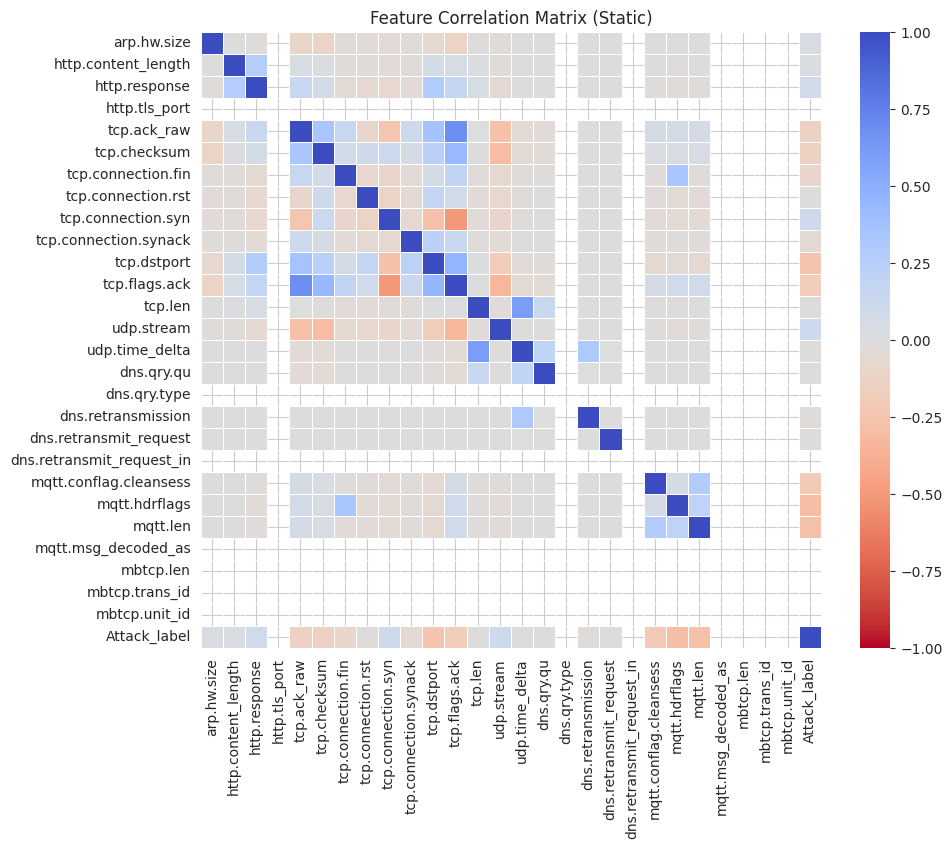

In [18]:

# dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, f1_score,
    roc_curve, auc
)
from itertools import cycle

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import os
# import joblib
# import pickle

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# --- Page Configuration ---
st.set_page_config(layout="wide", page_title="ML Model Interpretability Dashboard")

# --- Global Variables & Configuration ---
# !!! IMPORTANT: VERIFY THIS PATH IS CORRECT FOR YOUR GOOGLE DRIVE !!!
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv"


# --- Caching Functions for Performance ---
@st.cache_data
def load_and_preprocess_data(dataset_path):
    if not os.path.exists(dataset_path):
        st.error(f"CRITICAL ERROR: Dataset file not found at: {dataset_path}")
        st.error("Please ensure the path is correct, the file exists in your Google Drive, and Colab has access.")
        st.info("If you recently mounted Google Drive, re-run the mount cell or check the file path.")
        st.stop() # Stop execution if file not found
        return None, None, None, None, None, None

    try:
        df = pd.read_csv(dataset_path, low_memory=False)
        st.success(f"Dataset loaded successfully from {dataset_path}")
    except FileNotFoundError: # Specific catch for FileNotFoundError
        st.error(f"CRITICAL ERROR: Dataset file NOT FOUND at: {dataset_path}. Please check the path.")
        st.stop()
        return None, None, None, None, None, None
    except Exception as e:
        st.error(f"Error loading dataset: {e}")
        st.stop()
        return None, None, None, None, None, None

    df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
    df.dropna(inplace=True)
    if df.empty:
        st.warning("Dataset is empty after dropping NA values. Cannot proceed.")
        st.stop()
        return None, None, None, None, None, None

    if "Attack_label" not in df.columns:
        st.error("Target variable 'Attack_label' not found in the dataset columns.")
        st.stop()
        return None, None, None, None, None, None
    y = df["Attack_label"]
    classes = sorted(y.unique())
    n_classes = len(classes)

    # --- Comprehensive Feature Selection ---
    # !!! IMPORTANT: Review and customize this list if your dataset columns are different !!!
    drop_cols = [
        "frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
        "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp", "tcp.options",
        "tcp.payload", "mqtt.conack.flags", "mqtt.msg", "mqtt.protoname", "mqtt.topic",
        "mqtt.uuid", "mqtt.conflags", "icmp.unused", "http.request.method", "http.referer",
        "http.request.version", "dns.qry.name", "dns.resp.name", "tcp.flags", "udp.port",
        "tcp.port", "mqtt.conack.flags_tree",
        "tcp.options.mss", "tcp.window_size", "tcp.hdr_len", "tcp.seq", "tcp.ack",
        "ip.src", "ip.dst", "arp.opcode", "arp.hw.type", "arp.src.hw_mac", "arp.dst.hw_mac",
        "icmp.type", "icmp.code", "icmp.checksum", "icmp.ident", "icmp.seq_le",
        "udp.srcport", "udp.dstport", "udp.checksum", "dns.id", "dns.flags.response",
        "dns.flags.opcode", "dns.flags.authoritative", "dns.flags.truncated",
        "dns.flags.recursion_desired", "dns.flags.recursion_available", "dns.flags.z",
        "dns.flags.authenticated", "dns.flags.checking_disabled", "dns.flags.rcode",
        "dns.count.queries", "dns.count.answers", "dns.count.auth_rr", "dns.count.add_rr",
        "mqtt.clientid", "mqtt.qos", "mqtt.retain", "mqtt.dupflag", "mqtt.sessionpresent",
        "mqtt.proto_len", "mqtt.topic_len", "mqtt.ver", "mqtt.willmsg", "mqtt.willtopic",
        "mqtt.dup", "mqtt.msgtype", "mqtt.kalive", "mqtt.msgid", "mqtt.password",
        "mqtt.username", "mqtt.client_id_len", "mqtt.topic_val", "mqtt.msg_len",
        "mqtt.payload", "mqtt.ciphersuite", "mqtt.pk_id", "mqtt.reason_code",
        "mqtt.session_expiry_interval", "mqtt.will_flag", "mqtt.will_qos", "mqtt.will_retain",
        "mqtt.will_message_len", "mqtt.will_message", "mqtt.will_topic_len", "mqtt.will_topic",
        "mqtt.var_header.length", "mqtt.var_header.qos",
        # Add any other specific MQTT var_header.properties... columns here if needed
        # "mqtt.var_header.properties.message_expiry_interval", ... etc.
    ]
    # Columns that might be targets or labels, to be excluded from features X
    # Ensure "Attack_label" is used for y and not dropped from df before y is assigned.
    other_label_cols = ["Attack_type", "Label"]

    # Combine drop_cols with other_label_cols for creating X
    cols_to_drop_for_X = sorted(list(set(drop_cols + other_label_cols)))

    existing_cols_to_drop_for_X = [col for col in cols_to_drop_for_X if col in df.columns]

    X_candidate_features = df.drop(columns=existing_cols_to_drop_for_X, errors="ignore")
    X = X_candidate_features.select_dtypes(include=np.number)

    if X.empty:
        st.warning("No numeric features available after selection. Cannot proceed.")
        st.stop()
        return None, None, None, None, None, None

    feature_names_list = X.columns.tolist()
    if not feature_names_list:
        st.warning("Feature list is empty after selection. Cannot proceed.")
        st.stop()
        return None, None, None, None, None, None

    return df, X, y, classes, n_classes, feature_names_list

@st.cache_resource
def train_models_cached(X_train_scaled, y_train_orig, _models_config):
    trained_models_dict = {}
    for model_name, model_instance in _models_config.items():
        try:
            st.write(f"Training {model_name}...") # Give feedback during training
            model_instance.fit(X_train_scaled, y_train_orig)
            trained_models_dict[model_name] = model_instance
            st.write(f"{model_name} trained.")
        except Exception as e:
            st.error(f"Error training model {model_name}: {e}")
            trained_models_dict[model_name] = None
    return trained_models_dict

# --- Plotting Functions ---
def plot_target_distribution_plotly(y_data, classes_list):
    if y_data is None or y_data.empty: return None
    target_counts_df = y_data.value_counts().reindex(classes_list, fill_value=0).reset_index()
    target_counts_df.columns = ['Attack_Label', 'Count']
    fig = px.bar(target_counts_df, x='Attack_Label', y='Count',
                 title="Distribution of Target Variable (Attack_label)",
                 color='Attack_Label',
                 labels={'Count': 'Number of Occurrences', 'Attack_Label': 'Attack Label Type'},
                 color_discrete_sequence=px.colors.qualitative.Vivid)
    return fig

def plot_feature_distribution_plotly(X_data, feature_name, y_data_for_hue=None, n_classes_for_hue=0):
    if X_data is None or X_data.empty or feature_name not in X_data.columns: return None
    y_hue_str = y_data_for_hue.astype(str) if y_data_for_hue is not None else None
    fig = px.histogram(X_data, x=feature_name, color=y_hue_str if n_classes_for_hue > 1 and n_classes_for_hue <= 10 else None,
                       marginal="box", title=f"Distribution of {feature_name}",
                       color_discrete_sequence=px.colors.qualitative.Pastel if n_classes_for_hue > 1 and n_classes_for_hue <= 10 else None)
    return fig

def plot_correlation_matrix_seaborn(X_data):
    if X_data is None or X_data.empty or X_data.shape[1] < 2: return None
    fig = plt.figure(figsize=(10, 8))
    try:
        correlation_matrix = X_data.corr()
        sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm_r", linewidths=.5, vmin=-1, vmax=1, ax=fig.gca())
        plt.title("Feature Correlation Matrix (Static)")
    except Exception as e:
        st.warning(f"Could not generate correlation matrix: {e}")
        plt.close(fig)
        return None
    return fig # st.pyplot will handle this figure object

def plot_model_comparison_plotly(perf_df):
    if perf_df is None or perf_df.empty: return None
    perf_df_melted = perf_df.melt(id_vars='Model', var_name='Metric', value_name='Score',
                                  value_vars=['Test_Accuracy', 'Test_F1_Weighted'])
    fig = px.bar(perf_df_melted, x='Model', y='Score', color='Metric', barmode='group',
                 title='Model Performance Comparison (Test Set)',
                 labels={'Score': 'Metric Score', 'Model': 'Classifier Model'},
                 color_discrete_map={'Test_Accuracy': 'rgb(0,128,255)', 'Test_F1_Weighted': 'rgb(255,102,102)'})
    fig.update_layout(yaxis_title="Score", xaxis_title="Model", legend_title_text='Metric')
    return fig

def plot_confusion_matrix_seaborn(cm, labels, title, cmap="Blues"):
    if cm is None: return None
    fig = plt.figure(figsize=(8, 6))
    try:
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels, ax=fig.gca())
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    except Exception as e:
        st.warning(f"Could not generate confusion matrix plot: {e}")
        plt.close(fig)
        return None
    return fig

def plot_feature_importance_plotly(feature_importance_df, title):
    if feature_importance_df is None or feature_importance_df.empty: return None
    fig = px.bar(feature_importance_df, x='importance', y='feature', orientation='h',
                 title=title, color='importance', color_continuous_scale=px.colors.sequential.Viridis)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    return fig

def plot_roc_curves_plotly(y_test_binarized_data, y_test_proba_data, classes_list, n_classes_data, title):
    if y_test_proba_data is None: return None
    roc_data_list_plotly = []

    if n_classes_data == 2:
        positive_class_idx = 1 if classes_list[0] < classes_list[1] else 0 # Assuming classes_list is sorted [0, 1] or similar
        y_true_for_roc_binary = y_test_binarized_data[:, positive_class_idx]

        fpr, tpr, _ = roc_curve(y_true_for_roc_binary, y_test_proba_data[:, positive_class_idx])
        roc_auc = auc(fpr, tpr)
        df_roc = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
        positive_class_label_str = str(classes_list[positive_class_idx])
        df_roc['Class'] = f'{positive_class_label_str} (AUC = {roc_auc:.2f})'
        roc_data_list_plotly.append(df_roc)
    else: # Multi-class
        for i in range(n_classes_data):
            fpr, tpr, _ = roc_curve(y_test_binarized_data[:, i], y_test_proba_data[:, i])
            roc_auc = auc(fpr, tpr)
            df_roc = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
            df_roc['Class'] = f'Class {str(classes_list[i])} (AUC = {roc_auc:.2f})'
            roc_data_list_plotly.append(df_roc)
        # Micro-average
        fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_data.ravel(), y_test_proba_data.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        df_roc_micro = pd.DataFrame({'FPR': fpr_micro, 'TPR': tpr_micro})
        df_roc_micro['Class'] = f'Micro-avg (AUC = {roc_auc_micro:.2f})'
        roc_data_list_plotly.append(df_roc_micro)

    if not roc_data_list_plotly: return None
    full_roc_df = pd.concat(roc_data_list_plotly)
    fig = px.line(full_roc_df, x='FPR', y='TPR', color='Class', title=title,
                  labels={'FPR': 'False Positive Rate', 'TPR': 'True Positive Rate'},
                  color_discrete_sequence=px.colors.qualitative.Vivid)
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
    fig.update_layout(legend_title_text='Class / Average')
    return fig

# --- Main Dashboard App ---
def main():
    st.title("⚙️ Interactive Machine Learning Dashboard for Network Intrusion Detection")
    st.markdown("Explore data insights, compare model performances, and analyze individual model results.")

    data_load_state = st.text("Loading and preprocessing data...")
    # Assign to global_vars or pass around if needed, careful with scope in Streamlit
    # For simplicity, we'll re-assign to local vars in main() for now
    df_orig, X_orig, y_orig, classes_orig, n_classes_orig, feature_names_list_orig = load_and_preprocess_data(DATASET_PATH)

    if df_orig is None:
        return
    data_load_state.success("Data loaded and preprocessed successfully!")

    st.sidebar.header("Dashboard Navigation")
    app_mode = st.sidebar.radio("Choose a section:",
                                ["Data Overview", "Model Training & Evaluation", "Individual Model Analysis"])

    if app_mode == "Data Overview":
        st.header("📊 Data Overview")
        col1, col2 = st.columns(2)
        with col1:
            st.subheader("Dataset Shape")
            st.metric("Original DataFrame Rows", df_orig.shape[0])
            st.metric("Original DataFrame Columns", df_orig.shape[1])
        with col2:
            st.subheader("Processed Data Shape")
            st.metric("Features (X) Rows", X_orig.shape[0])
            st.metric("Features (X) Columns", X_orig.shape[1])

        st.subheader("Target Variable: Attack_label")
        st.metric(f"Number of classes", n_classes_orig)
        st.write(f"Class labels: `{', '.join(map(str, classes_orig))}`")
        fig_target_dist = plot_target_distribution_plotly(y_orig, classes_orig)
        if fig_target_dist: st.plotly_chart(fig_target_dist, use_container_width=True)

        st.subheader("Sample Numerical Feature Distributions")
        if not X_orig.empty and feature_names_list_orig:
            default_features = feature_names_list_orig[:min(3, len(feature_names_list_orig))]
            selected_features_dist = st.multiselect("Select features to view distribution:",
                                                    options=feature_names_list_orig,
                                                    default=default_features)
            if selected_features_dist:
                for feature in selected_features_dist:
                    fig_feat_dist = plot_feature_distribution_plotly(X_orig, feature, y_orig, n_classes_orig)
                    if fig_feat_dist: st.plotly_chart(fig_feat_dist, use_container_width=True)

        st.subheader("Feature Correlation Matrix")
        fig_corr = plot_correlation_matrix_seaborn(X_orig)
        if fig_corr:
            st.pyplot(fig_corr)
        else:
            st.info("Not enough features or an error occurred for correlation matrix.")

    # Cache model training and evaluation results to avoid re-computation on every interaction within these sections
    # This dictionary will store all results once computed for the session
    if 'model_results_cache' not in st.session_state:
        st.session_state.model_results_cache = {}

    # Shared model training and evaluation logic for relevant modes
    if app_mode == "Model Training & Evaluation" or app_mode == "Individual Model Analysis":
        if not st.session_state.model_results_cache: # Only run if cache is empty
            with st.spinner("Splitting data, scaling, and training/evaluating models... This may take a few moments."):
                models_config = {
                    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
                    "DecisionTree": DecisionTreeClassifier(random_state=42),
                    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
                    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss' if n_classes_orig > 2 else 'logloss', use_label_encoder=False)
                }

                y_for_split = y_orig
                X_train_orig_df, X_test_orig_df, y_train_orig_series, y_test_orig_series = train_test_split(
                    X_orig, y_for_split, test_size=0.25, random_state=42, stratify=y_for_split
                )

                scaler = StandardScaler()
                X_train_scaled_arr = scaler.fit_transform(X_train_orig_df)
                X_test_scaled_arr = scaler.transform(X_test_orig_df)
                y_test_binarized_arr = label_binarize(y_test_orig_series, classes=classes_orig)

                trained_models = train_models_cached(X_train_scaled_arr, y_train_orig_series, models_config)

                if not any(trained_models.values()):
                    st.error("All models failed to train. Please check data and configurations.")
                    st.stop()
                else:
                    st.success("Models trained (or loaded from cache) and ready for evaluation!")

                model_performance_list = []
                for model_name, model_instance in trained_models.items():
                    if model_instance is None: continue
                    y_test_pred = model_instance.predict(X_test_scaled_arr)
                    y_test_proba = model_instance.predict_proba(X_test_scaled_arr) if hasattr(model_instance, "predict_proba") else None
                    accuracy = accuracy_score(y_test_orig_series, y_test_pred)
                    f1 = f1_score(y_test_orig_series, y_test_pred, average='weighted', zero_division=0)
                    cm = confusion_matrix(y_test_orig_series, y_test_pred, labels=classes_orig)
                    report_str = classification_report(y_test_orig_series, y_test_pred, target_names=[str(c) for c in classes_orig], zero_division=0)
                    feature_importances_df = None
                    if hasattr(model_instance, 'feature_importances_') and feature_names_list_orig:
                        importances = model_instance.feature_importances_
                        feature_importances_df = pd.DataFrame({'feature': feature_names_list_orig, 'importance': importances})
                        feature_importances_df = feature_importances_df.sort_values('importance', ascending=False).head(15)

                    model_performance_list.append({'Model': model_name, 'Test_Accuracy': accuracy, 'Test_F1_Weighted': f1})
                    st.session_state.model_results_cache[model_name] = {
                        'accuracy': accuracy, 'f1_weighted': f1, 'cm': cm,
                        'classification_report': report_str, 'feature_importances': feature_importances_df,
                        'y_test_proba': y_test_proba, 'y_test_binarized_for_roc': y_test_binarized_arr # Store this for ROC
                    }
                st.session_state.model_results_cache['performance_summary_df'] = pd.DataFrame(model_performance_list)
                st.session_state.model_results_cache['model_names_list'] = list(models_config.keys()) # Store model names

        # Now use the cached results
        performance_summary_df = st.session_state.model_results_cache.get('performance_summary_df')
        all_models_results_data = {k:v for k,v in st.session_state.model_results_cache.items() if k not in ['performance_summary_df', 'model_names_list']}
        model_names_list_cached = st.session_state.model_results_cache.get('model_names_list', [])


        if app_mode == "Model Training & Evaluation":
            st.header("🚀 Model Performance Comparison")
            if performance_summary_df is not None:
                fig_model_comp = plot_model_comparison_plotly(performance_summary_df)
                if fig_model_comp: st.plotly_chart(fig_model_comp, use_container_width=True)
            else:
                st.info("Performance data not available to display comparison chart.")

        elif app_mode == "Individual Model Analysis":
            st.header("🔎 Individual Model Deep Dive")
            if not model_names_list_cached:
                st.warning("Models have not been trained/evaluated yet in this session. Please go to 'Model Training & Evaluation' section first or refresh if it was just run.")
            else:
                selected_model_name = st.sidebar.selectbox("Select a Model to Analyze:", model_names_list_cached, key="model_select_deep_dive")

                if selected_model_name and selected_model_name in all_models_results_data:
                    model_results = all_models_results_data[selected_model_name]
                    st.subheader(f"Results for: {selected_model_name}")
                    col_m1, col_m2 = st.columns(2)
                    with col_m1: st.metric(label="Test Accuracy", value=f"{model_results['accuracy']:.4f}")
                    with col_m2: st.metric(label="Test F1 Score (Weighted)", value=f"{model_results['f1_weighted']:.4f}")

                    st.subheader("Confusion Matrix (Test Set)")
                    fig_cm = plot_confusion_matrix_seaborn(model_results['cm'], classes_orig, f"{selected_model_name} - Confusion Matrix", cmap="viridis")
                    if fig_cm: st.pyplot(fig_cm)

                    if model_results['y_test_proba'] is not None:
                        st.subheader("ROC Curve (Test Set)")
                        y_test_binarized_for_roc = model_results.get('y_test_binarized_for_roc') # Get from cache
                        if y_test_binarized_for_roc is not None:
                            fig_roc = plot_roc_curves_plotly(y_test_binarized_for_roc, model_results['y_test_proba'], classes_orig, n_classes_orig, f"{selected_model_name} - ROC Curves")
                            if fig_roc: st.plotly_chart(fig_roc, use_container_width=True)
                        else:
                             st.warning("Binarized y_test data for ROC not found in cache.")
                    else:
                        st.info(f"Probability scores for ROC curve are not available for {selected_model_name}.")

                    if model_results['feature_importances'] is not None and not model_results['feature_importances'].empty:
                        st.subheader("Feature Importances (Top 15)")
                        fig_fi = plot_feature_importance_plotly(model_results['feature_importances'], f"{selected_model_name} - Feature Importances")
                        if fig_fi: st.plotly_chart(fig_fi, use_container_width=True)
                    else:
                        st.info(f"Feature importances are not available for {selected_model_name}.")

                    st.subheader("Classification Report (Test Set)")
                    st.text_area("Report:", model_results['classification_report'], height=300)
                elif selected_model_name:
                    st.warning(f"Results for selected model '{selected_model_name}' are not available.")

    st.sidebar.markdown("---")
    st.sidebar.info("Dashboard for ML Model Analysis.")

if __name__ == "__main__":
    main()


In [21]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.247.29:8501

  Stopping...
^C


In [23]:
!ngrok config add-authtoken 2xxqhIlWEeul7tgzJRqxqDrTood_7T7buS2eiSj8BTU4ZThNV

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [26]:
# dashboard.py
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, f1_score,
    roc_curve, auc
)
from itertools import cycle

# Model-specific imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import os
# import joblib
# import pickle

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# --- Page Configuration ---
st.set_page_config(layout="wide", page_title="ML Model Interpretability Dashboard")

# --- Global Variables & Configuration ---
# !!! IMPORTANT: VERIFY THIS PATH IS CORRECT FOR YOUR GOOGLE DRIVE !!!
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/datasets/ML-EdgeIIoT-dataset.csv"


# --- Caching Functions for Performance ---
@st.cache_data
def load_and_preprocess_data(dataset_path):
    if not os.path.exists(dataset_path):
        st.error(f"CRITICAL ERROR: Dataset file not found at: {dataset_path}")
        st.error("Please ensure the path is correct, the file exists in your Google Drive, and Colab has access.")
        st.info("If you recently mounted Google Drive, re-run the mount cell or check the file path.")
        st.stop()
        return None, None, None, None, None, None

    try:
        df = pd.read_csv(dataset_path, low_memory=False)
    except FileNotFoundError:
        st.error(f"CRITICAL ERROR: Dataset file NOT FOUND at: {dataset_path}. Please check the path.")
        st.stop()
        return None, None, None, None, None, None
    except Exception as e:
        st.error(f"Error loading dataset: {e}")
        st.stop()
        return None, None, None, None, None, None

    df.replace([float("inf"), float("-inf")], pd.NA, inplace=True)
    df.dropna(inplace=True)
    if df.empty:
        st.warning("Dataset is empty after dropping NA values. Cannot proceed.")
        st.stop()
        return None, None, None, None, None, None

    if "Attack_label" not in df.columns:
        st.error("Target variable 'Attack_label' not found in the dataset columns.")
        st.stop()
        return None, None, None, None, None, None
    y = df["Attack_label"]
    classes = sorted(y.unique())
    n_classes = len(classes)

    drop_cols = [
        "frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4", "arp.dst.proto_ipv4",
        "http.file_data", "http.request.full_uri", "icmp.transmit_timestamp", "tcp.options",
        "tcp.payload", "mqtt.conack.flags", "mqtt.msg", "mqtt.protoname", "mqtt.topic",
        "mqtt.uuid", "mqtt.conflags", "icmp.unused", "http.request.method", "http.referer",
        "http.request.version", "dns.qry.name", "dns.resp.name", "tcp.flags", "udp.port",
        "tcp.port", "mqtt.conack.flags_tree",
        "tcp.options.mss", "tcp.window_size", "tcp.hdr_len", "tcp.seq", "tcp.ack",
        "ip.src", "ip.dst", "arp.opcode", "arp.hw.type", "arp.src.hw_mac", "arp.dst.hw_mac",
        "icmp.type", "icmp.code", "icmp.checksum", "icmp.ident", "icmp.seq_le",
        "udp.srcport", "udp.dstport", "udp.checksum", "dns.id", "dns.flags.response",
        "dns.flags.opcode", "dns.flags.authoritative", "dns.flags.truncated",
        "dns.flags.recursion_desired", "dns.flags.recursion_available", "dns.flags.z",
        "dns.flags.authenticated", "dns.flags.checking_disabled", "dns.flags.rcode",
        "dns.count.queries", "dns.count.answers", "dns.count.auth_rr", "dns.count.add_rr",
        "mqtt.clientid", "mqtt.qos", "mqtt.retain", "mqtt.dupflag", "mqtt.sessionpresent",
        "mqtt.proto_len", "mqtt.topic_len", "mqtt.ver", "mqtt.willmsg", "mqtt.willtopic",
        "mqtt.dup", "mqtt.msgtype", "mqtt.kalive", "mqtt.msgid", "mqtt.password",
        "mqtt.username", "mqtt.client_id_len", "mqtt.topic_val", "mqtt.msg_len",
        "mqtt.payload", "mqtt.ciphersuite", "mqtt.pk_id", "mqtt.reason_code",
        "mqtt.session_expiry_interval", "mqtt.will_flag", "mqtt.will_qos", "mqtt.will_retain",
        "mqtt.will_message_len", "mqtt.will_message", "mqtt.will_topic_len", "mqtt.will_topic",
        "mqtt.var_header.length", "mqtt.var_header.qos",
    ]
    other_label_cols = ["Attack_type", "Label"]
    cols_to_drop_for_X = sorted(list(set(drop_cols + other_label_cols)))
    existing_cols_to_drop_for_X = [col for col in cols_to_drop_for_X if col in df.columns]

    X_candidate_features = df.drop(columns=existing_cols_to_drop_for_X, errors="ignore")
    X = X_candidate_features.select_dtypes(include=np.number)

    if X.empty:
        st.warning("No numeric features available after selection. Cannot proceed.")
        st.stop()
        return None, None, None, None, None, None

    feature_names_list = X.columns.tolist()
    if not feature_names_list:
        st.warning("Feature list is empty after selection. Cannot proceed.")
        st.stop()
        return None, None, None, None, None, None

    return df, X, y, classes, n_classes, feature_names_list

@st.cache_resource
def train_models_cached(X_train_scaled, y_train_orig, _models_config):
    trained_models_dict = {}
    for model_name, model_instance in _models_config.items():
        try:
            model_instance.fit(X_train_scaled, y_train_orig)
            trained_models_dict[model_name] = model_instance
        except Exception as e:
            st.error(f"Error training model {model_name}: {e}")
            trained_models_dict[model_name] = None
    return trained_models_dict

# --- Plotting Functions ---
def plot_target_distribution_plotly(y_data, classes_list):
    if y_data is None or y_data.empty: return None
    target_counts_df = y_data.value_counts().reindex(classes_list, fill_value=0).reset_index()
    target_counts_df.columns = ['Attack_Label', 'Count']
    fig = px.bar(target_counts_df, x='Attack_Label', y='Count',
                 title="Distribution of Target Variable (Attack_label)",
                 color='Attack_Label',
                 labels={'Count': 'Number of Occurrences', 'Attack_Label': 'Attack Label Type'},
                 color_discrete_sequence=px.colors.qualitative.Vivid)
    return fig

def plot_feature_distribution_plotly(X_data, feature_name, y_data_for_hue=None, n_classes_for_hue=0):
    if X_data is None or X_data.empty or feature_name not in X_data.columns: return None
    y_hue_str = y_data_for_hue.astype(str) if y_data_for_hue is not None else None
    fig = px.histogram(X_data, x=feature_name, color=y_hue_str if n_classes_for_hue > 1 and n_classes_for_hue <= 10 else None,
                       marginal="box", title=f"Distribution of {feature_name}",
                       color_discrete_sequence=px.colors.qualitative.Pastel if n_classes_for_hue > 1 and n_classes_for_hue <= 10 else None)
    return fig

def plot_correlation_matrix_seaborn(X_data):
    if X_data is None or X_data.empty or X_data.shape[1] < 2: return None
    fig = plt.figure(figsize=(10, 8))
    try:
        correlation_matrix = X_data.corr()
        sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm_r", linewidths=.5, vmin=-1, vmax=1, ax=fig.gca())
        plt.title("Feature Correlation Matrix (Static)")
    except Exception as e:
        print(f"[Plotting Warning] Could not generate correlation matrix: {e}")
        plt.close(fig)
        return None
    return fig

def plot_model_comparison_plotly(perf_df):
    if perf_df is None or perf_df.empty: return None
    perf_df_melted = perf_df.melt(id_vars='Model', var_name='Metric', value_name='Score',
                                  value_vars=['Test_Accuracy', 'Test_F1_Weighted'])
    fig = px.bar(perf_df_melted, x='Model', y='Score', color='Metric', barmode='group',
                 title='Model Performance Comparison (Test Set)',
                 labels={'Score': 'Metric Score', 'Model': 'Classifier Model'},
                 color_discrete_map={'Test_Accuracy': 'rgb(0,128,255)', 'Test_F1_Weighted': 'rgb(255,102,102)'})
    fig.update_layout(yaxis_title="Score", xaxis_title="Model", legend_title_text='Metric')
    return fig

def plot_confusion_matrix_seaborn(cm, labels, title, cmap="Blues"):
    if cm is None: return None
    fig = plt.figure(figsize=(8, 6))
    try:
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels, ax=fig.gca())
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
    except Exception as e:
        print(f"[Plotting Warning] Could not generate confusion matrix plot: {e}")
        plt.close(fig)
        return None
    return fig

def plot_feature_importance_plotly(feature_importance_df, title):
    if feature_importance_df is None or feature_importance_df.empty: return None
    fig = px.bar(feature_importance_df, x='importance', y='feature', orientation='h',
                 title=title, color='importance', color_continuous_scale=px.colors.sequential.Viridis)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    return fig

def plot_roc_curves_plotly(y_test_binarized_data, y_test_proba_data, classes_list, n_classes_data, title):
    if y_test_proba_data is None:
        st.info(f"Probability scores not available for ROC curve in {title.split(' - ')[0]}.")
        return None
    roc_data_list_plotly = []

    if n_classes_data == 2:
        # y_test_binarized_data for binary from label_binarize(y, classes=sorted_classes) is (n_samples, 1)
        # This single column is y_true (0s and 1s).
        y_true_for_roc = y_test_binarized_data.ravel()

        # y_test_proba_data is (n_samples, 2). We need probabilities for the positive class.
        # Scikit-learn's predict_proba for binary classifiers usually orders columns based on sorted class labels.
        # If classes_list is sorted (e.g., [0, 1] or ['Normal', 'Attack']),
        # the second column (index 1) typically corresponds to the "positive" or higher-label class.
        if y_test_proba_data.shape[1] == 2:
            y_score_for_roc = y_test_proba_data[:, 1]
        else:
            # Fallback if somehow probabilities are not (n_samples, 2)
            st.warning(f"Expected 2 columns in y_test_proba_data for binary ROC in {title.split(' - ')[0]}, but found shape {y_test_proba_data.shape}. Using ravel().")
            y_score_for_roc = y_test_proba_data.ravel() # This might be incorrect if not 1D array of positive class probas

        fpr, tpr, _ = roc_curve(y_true_for_roc, y_score_for_roc)
        roc_auc = auc(fpr, tpr)
        df_roc = pd.DataFrame({'FPR': fpr, 'TPR': tpr})

        # Determine the positive class label string from classes_list (it's sorted)
        positive_class_label_str = str(classes_list[1]) if len(classes_list) > 1 else str(classes_list[0])
        df_roc['Class'] = f'{positive_class_label_str} (AUC = {roc_auc:.2f})'
        roc_data_list_plotly.append(df_roc)
    else: # Multi-class
        for i in range(n_classes_data):
            fpr, tpr, _ = roc_curve(y_test_binarized_data[:, i], y_test_proba_data[:, i])
            roc_auc = auc(fpr, tpr)
            df_roc = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
            df_roc['Class'] = f'Class {str(classes_list[i])} (AUC = {roc_auc:.2f})'
            roc_data_list_plotly.append(df_roc)

        # Micro-average ROC for multi-class
        fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_data.ravel(), y_test_proba_data.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        df_roc_micro = pd.DataFrame({'FPR': fpr_micro, 'TPR': tpr_micro})
        df_roc_micro['Class'] = f'Micro-avg (AUC = {roc_auc_micro:.2f})'
        roc_data_list_plotly.append(df_roc_micro)

    if not roc_data_list_plotly: return None
    full_roc_df = pd.concat(roc_data_list_plotly)
    fig = px.line(full_roc_df, x='FPR', y='TPR', color='Class', title=title,
                  labels={'FPR': 'False Positive Rate', 'TPR': 'True Positive Rate'},
                  color_discrete_sequence=px.colors.qualitative.Vivid)
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
    fig.update_layout(legend_title_text='Class / Average')
    return fig

# --- Main Dashboard App ---
def main():
    st.title("⚙️ Interactive Machine Learning Dashboard for Network Intrusion Detection")
    st.markdown("Explore data insights, compare model performances, and analyze individual model results.")

    if 'data_loaded' not in st.session_state:
        st.session_state.data_loaded = False
    if 'data_vars' not in st.session_state:
        st.session_state.data_vars = {}
    if 'model_results_cache' not in st.session_state: # Initialize model results cache
        st.session_state.model_results_cache = {}


    if not st.session_state.data_loaded:
        with st.spinner("Loading and preprocessing data... This may take a moment on first run."):
            # Call the function to load data
            df_orig, X_orig, y_orig, classes_orig, n_classes_orig, feature_names_list_orig = load_and_preprocess_data(DATASET_PATH)

            # Store loaded variables in session state if successful
            if df_orig is not None: # Check if st.stop() was called
                st.session_state.data_vars['df_orig'] = df_orig
                st.session_state.data_vars['X_orig'] = X_orig
                st.session_state.data_vars['y_orig'] = y_orig
                st.session_state.data_vars['classes_orig'] = classes_orig
                st.session_state.data_vars['n_classes_orig'] = n_classes_orig
                st.session_state.data_vars['feature_names_list_orig'] = feature_names_list_orig
                st.session_state.data_loaded = True
                st.success("Data loaded and preprocessed successfully!")
            else:
                # load_and_preprocess_data would have called st.error and st.stop()
                return # Exit main if data loading failed

    # Retrieve data from session state
    df_orig = st.session_state.data_vars.get('df_orig')
    X_orig = st.session_state.data_vars.get('X_orig')
    y_orig = st.session_state.data_vars.get('y_orig')
    classes_orig = st.session_state.data_vars.get('classes_orig')
    n_classes_orig = st.session_state.data_vars.get('n_classes_orig')
    feature_names_list_orig = st.session_state.data_vars.get('feature_names_list_orig')

    if not st.session_state.data_loaded or not all([X_orig is not None, y_orig is not None, classes_orig is not None, feature_names_list_orig is not None]):
        st.error("Data variables not properly loaded into session state. Please ensure data loading was successful or try refreshing.")
        st.stop()

    st.sidebar.header("Dashboard Navigation")
    app_mode = st.sidebar.radio("Choose a section:",
                                ["Data Overview", "Model Training & Evaluation", "Individual Model Analysis"], key="app_mode_radio")

    if app_mode == "Data Overview":
        st.header("📊 Data Overview")
        col1, col2 = st.columns(2)
        with col1:
            st.subheader("Dataset Shape")
            st.metric("Original DataFrame Rows", df_orig.shape[0])
            st.metric("Original DataFrame Columns", df_orig.shape[1])
        with col2:
            st.subheader("Processed Data Shape")
            st.metric("Features (X) Rows", X_orig.shape[0])
            st.metric("Features (X) Columns", X_orig.shape[1])

        st.subheader("Target Variable: Attack_label")
        st.metric(f"Number of classes", n_classes_orig)
        st.write(f"Class labels: `{', '.join(map(str, classes_orig))}`")
        fig_target_dist = plot_target_distribution_plotly(y_orig, classes_orig)
        if fig_target_dist: st.plotly_chart(fig_target_dist, use_container_width=True)

        st.subheader("Sample Numerical Feature Distributions")
        if not X_orig.empty and feature_names_list_orig:
            default_features = feature_names_list_orig[:min(3, len(feature_names_list_orig))]
            selected_features_dist = st.multiselect("Select features to view distribution:",
                                                    options=feature_names_list_orig,
                                                    default=default_features, key="feature_dist_select")
            if selected_features_dist:
                for feature in selected_features_dist:
                    fig_feat_dist = plot_feature_distribution_plotly(X_orig, feature, y_orig, n_classes_orig)
                    if fig_feat_dist: st.plotly_chart(fig_feat_dist, use_container_width=True)

        st.subheader("Feature Correlation Matrix")
        fig_corr = plot_correlation_matrix_seaborn(X_orig)
        if fig_corr:
            st.pyplot(fig_corr)
        else:
            st.info("Correlation matrix could not be generated (e.g., not enough numeric features).")

    elif app_mode == "Model Training & Evaluation" or app_mode == "Individual Model Analysis":
        # Check if results are already cached in session_state
        if not st.session_state.model_results_cache or 'model_names_list' not in st.session_state.model_results_cache:
            with st.spinner("Splitting data, scaling, and training/evaluating models... This can take time."):
                models_config = {
                    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
                    "DecisionTree": DecisionTreeClassifier(random_state=42),
                    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear', max_iter=1000),
                    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss' if n_classes_orig > 2 else 'logloss', use_label_encoder=False)
                }

                y_for_split = y_orig
                X_train_orig_df, X_test_orig_df, y_train_orig_series, y_test_orig_series = train_test_split(
                    X_orig, y_for_split, test_size=0.25, random_state=42, stratify=y_for_split
                )

                scaler = StandardScaler()
                X_train_scaled_arr = scaler.fit_transform(X_train_orig_df)
                X_test_scaled_arr = scaler.transform(X_test_orig_df)
                y_test_binarized_arr = label_binarize(y_test_orig_series, classes=classes_orig)

                trained_models = train_models_cached(X_train_scaled_arr, y_train_orig_series, models_config)

                if not any(trained_models.values()): # Check if all models failed to train
                    st.error("All models failed to train. Please check data, configurations, and logs.")
                    st.stop() # Stop if all models fail
                else:
                    st.success("Models trained (or loaded from resource cache) and ready for evaluation!")

                model_performance_list_local = [] # Use local var before assigning to session state
                # Create a temporary dict for current run's results before assigning to session_state
                current_run_results = {}

                for model_name, model_instance in trained_models.items():
                    if model_instance is None: continue
                    y_test_pred = model_instance.predict(X_test_scaled_arr)
                    y_test_proba = model_instance.predict_proba(X_test_scaled_arr) if hasattr(model_instance, "predict_proba") else None
                    accuracy = accuracy_score(y_test_orig_series, y_test_pred)
                    f1 = f1_score(y_test_orig_series, y_test_pred, average='weighted', zero_division=0)
                    cm = confusion_matrix(y_test_orig_series, y_test_pred, labels=classes_orig)
                    report_str = classification_report(y_test_orig_series, y_test_pred, target_names=[str(c) for c in classes_orig], zero_division=0)

                    feature_importances_df = None
                    if hasattr(model_instance, 'feature_importances_') and feature_names_list_orig:
                        importances = model_instance.feature_importances_
                        feature_importances_df = pd.DataFrame({'feature': feature_names_list_orig, 'importance': importances})
                        feature_importances_df = feature_importances_df.sort_values('importance', ascending=False).head(15)

                    model_performance_list_local.append({'Model': model_name, 'Test_Accuracy': accuracy, 'Test_F1_Weighted': f1})
                    current_run_results[model_name] = {
                        'accuracy': accuracy, 'f1_weighted': f1, 'cm': cm,
                        'classification_report': report_str, 'feature_importances': feature_importances_df,
                        'y_test_proba': y_test_proba,
                        'y_test_binarized_for_roc': y_test_binarized_arr # Store the common binarized y_test
                    }

                # Update session state cache AFTER the loop
                for mn, m_res in current_run_results.items():
                    st.session_state.model_results_cache[mn] = m_res
                st.session_state.model_results_cache['performance_summary_df'] = pd.DataFrame(model_performance_list_local)
                st.session_state.model_results_cache['model_names_list'] = list(models_config.keys())

        # Retrieve from session state cache for display
        performance_summary_df = st.session_state.model_results_cache.get('performance_summary_df')
        # Ensure all_models_results_data is populated from the cache correctly
        all_models_results_data = {k:v for k,v in st.session_state.model_results_cache.items() if k not in ['performance_summary_df', 'model_names_list']}
        model_names_list_cached = st.session_state.model_results_cache.get('model_names_list', [])

        if app_mode == "Model Training & Evaluation":
            st.header("🚀 Model Performance Comparison")
            if performance_summary_df is not None and not performance_summary_df.empty:
                fig_model_comp = plot_model_comparison_plotly(performance_summary_df)
                if fig_model_comp: st.plotly_chart(fig_model_comp, use_container_width=True)
            else:
                st.info("Performance data not yet available or models not trained. Please wait or check logs.")

        elif app_mode == "Individual Model Analysis":
            st.header("🔎 Individual Model Deep Dive")
            if not model_names_list_cached:
                st.warning("Models have not been trained/evaluated yet in this session. Please wait if training is in progress or check logs.")
            else:
                selected_model_name = st.sidebar.selectbox("Select a Model to Analyze:", model_names_list_cached, key="model_select_deep_dive_v3")

                if selected_model_name and selected_model_name in all_models_results_data:
                    model_results = all_models_results_data[selected_model_name]
                    st.subheader(f"Results for: {selected_model_name}")
                    col_m1, col_m2 = st.columns(2)
                    with col_m1: st.metric(label="Test Accuracy", value=f"{model_results['accuracy']:.4f}")
                    with col_m2: st.metric(label="Test F1 Score (Weighted)", value=f"{model_results['f1_weighted']:.4f}")

                    st.subheader("Confusion Matrix (Test Set)")
                    fig_cm = plot_confusion_matrix_seaborn(model_results['cm'], classes_orig, f"{selected_model_name} - CM", cmap="viridis")
                    if fig_cm: st.pyplot(fig_cm)

                    if model_results.get('y_test_proba') is not None:
                        st.subheader("ROC Curve (Test Set)")
                        y_test_binarized_for_roc_sel = model_results.get('y_test_binarized_for_roc')
                        if y_test_binarized_for_roc_sel is not None:
                            fig_roc = plot_roc_curves_plotly(y_test_binarized_for_roc_sel, model_results['y_test_proba'], classes_orig, n_classes_orig, f"{selected_model_name} - ROC Curves")
                            if fig_roc: st.plotly_chart(fig_roc, use_container_width=True)
                        else:
                             st.warning("Binarized y_test data for ROC not found in cache for this model. This should have been prepared during model evaluation.")
                    else:
                        st.info(f"Probability scores for ROC curve are not available for {selected_model_name} (model might not support predict_proba).")

                    if model_results.get('feature_importances') is not None and not model_results['feature_importances'].empty:
                        st.subheader("Feature Importances (Top 15)")
                        fig_fi = plot_feature_importance_plotly(model_results['feature_importances'], f"{selected_model_name} - Feature Importances")
                        if fig_fi: st.plotly_chart(fig_fi, use_container_width=True)
                    else:
                        st.info(f"Feature importances are not available or empty for {selected_model_name}.")

                    st.subheader("Classification Report (Test Set)")
                    st.text_area("Report:", model_results['classification_report'], height=300, key=f"report_{selected_model_name}")
                elif selected_model_name: # Only show if a selection was made but data not found
                    st.warning(f"Results for selected model '{selected_model_name}' are not available (e.g., it might have failed during training or not processed yet).")

    st.sidebar.markdown("---")
    st.sidebar.info("ML Dashboard v2.1")

if __name__ == "__main__":
    main()

2025-06-02 19:25:48.727 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.728 No runtime found, using MemoryCacheStorageManager
2025-06-02 19:25:48.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.735 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.737 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 19:25:48.738 Thread 'MainThread':

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Model Evaluation Summary


,Model,Accuracy,F1-Score
0,Random Forest,0.976616,0.976546
1,Decision Tree,0.972148,0.972109
2,Logistic Regression,0.843283,0.785103
3,XGBoost,0.976901,0.976849


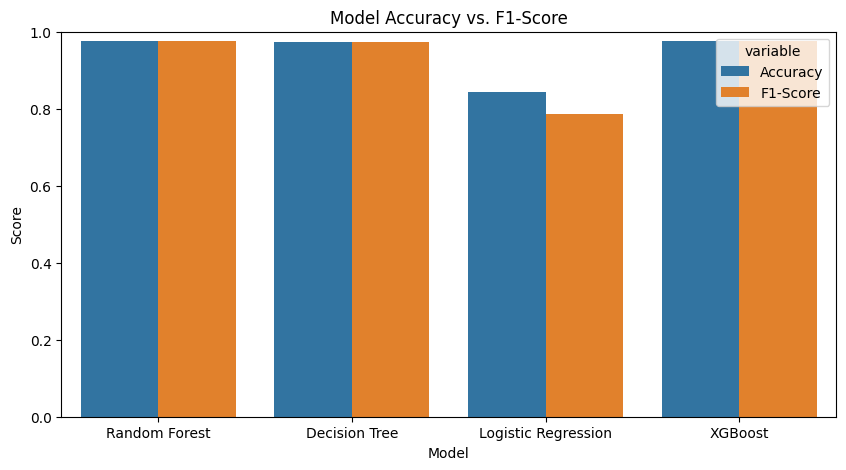

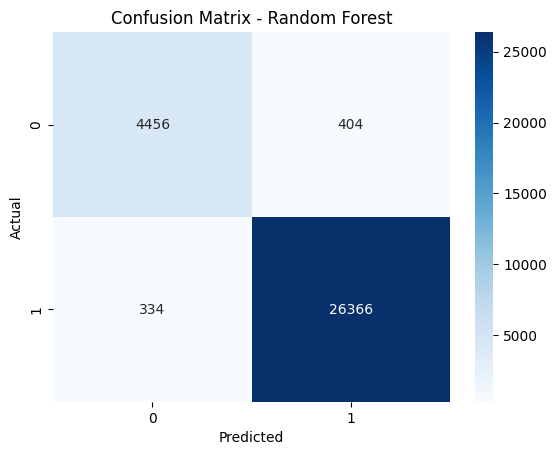

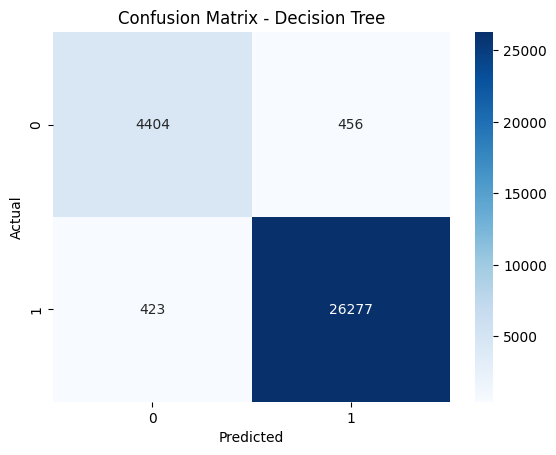

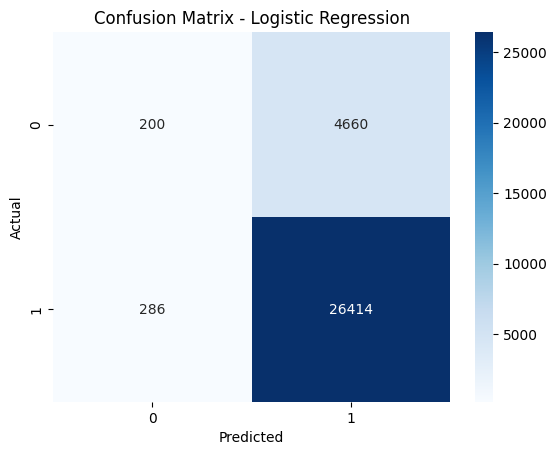

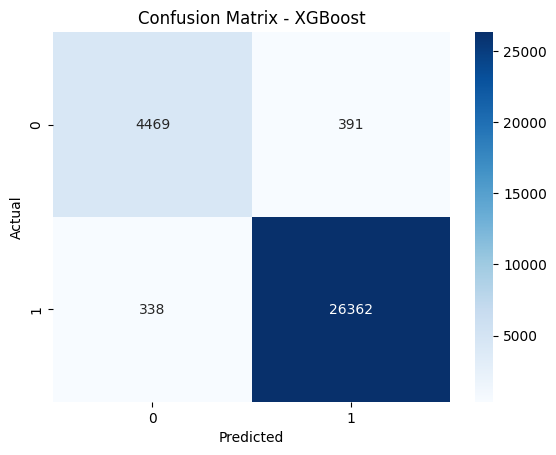

In [3]:
# Imports
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Your X and y (after feature selection)
# X, y = ...

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Model dictionary
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []
conf_matrices = {}

# Training and Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1
    })

    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    # Save model
    joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

# DataFrame for comparison
results_df = pd.DataFrame(results)

# Show comparison table
print("🔍 Model Evaluation Summary")
display(results_df)

# Bar plot
plt.figure(figsize=(10,5))
sns.barplot(data=results_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Model Accuracy vs. F1-Score")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

# Confusion Matrices
for name, cm in conf_matrices.items():
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


<ipython-input-4-1f5c173b74dd>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(results_df, x='F1-Score', y='Model', inner='stick', palette='Dark2')


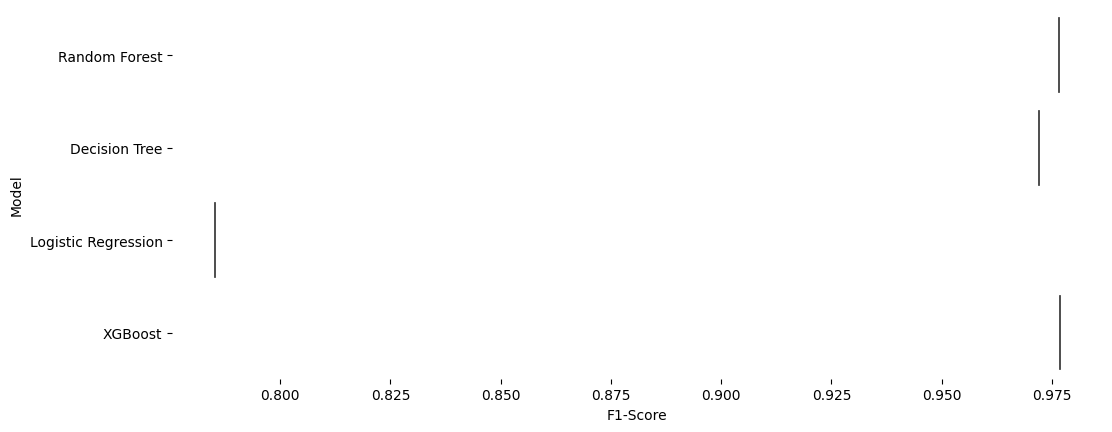

In [4]:
# @title Model vs F1-Score

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='F1-Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [5]:
!pip install streamlit scikit-learn matplotlib seaborn joblib


In [6]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# ------------------------------
st.title("🔍 ML Model Comparison Dashboard")
st.markdown("Compare multiple models side-by-side on your dataset")

# Sample data loading
st.sidebar.header("📂 Upload Preprocessed Data")
uploaded = st.sidebar.file_uploader("Upload your CSV file", type=["csv"])

if uploaded:
    df = pd.read_csv(uploaded)
    st.success("✅ Data uploaded successfully.")
    target_column = st.sidebar.selectbox("🎯 Select Target Column", df.columns)

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Encode labels
    lb = LabelBinarizer()
    y = lb.fit_transform(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    models = {
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "XGBoost": XGBClassifier(eval_metric='logloss')
    }

    results = []
    st.header("📊 Model Evaluation")

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['weighted avg']['f1-score']

        cm = confusion_matrix(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1-Score": f1,
            "AUC": roc_auc,
            "Confusion Matrix": cm,
            "FPR": fpr,
            "TPR": tpr
        })

        # Save model
        joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

    results_df = pd.DataFrame([
        {"Model": r["Model"], "Accuracy": r["Accuracy"], "F1-Score": r["F1-Score"], "AUC": r["AUC"]}
        for r in results
    ])

    st.dataframe(results_df.style.highlight_max(axis=0))

    best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
    st.success(f"🏆 Best Model: **{best_model}**")

    st.subheader("📉 Visual Comparison")
    chart_metric = st.selectbox("Select metric to visualize", ["Accuracy", "F1-Score", "AUC"])
    fig, ax = plt.subplots()
    sns.barplot(data=results_df, x="Model", y=chart_metric, ax=ax)
    ax.set_title(f"{chart_metric} by Model")
    st.pyplot(fig)

    # ROC Curves
    st.subheader("📈 ROC Curves")
    for r in results:
        plt.plot(r["FPR"], r["TPR"], label=f'{r["Model"]} (AUC = {r["AUC"]:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    st.pyplot(plt)

    # Confusion Matrices
    st.subheader("🧾 Confusion Matrices")
    for r in results:
        st.write(f"**{r['Model']}**")
        fig, ax = plt.subplots()
        sns.heatmap(r["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax)
        st.pyplot(fig)

    st.sidebar.download_button(
        label="📦 Download Best Model",
        data=open(f"{best_model.replace(' ', '_')}_model.pkl", "rb").read(),
        file_name=f"{best_model.replace(' ', '_')}_model.pkl"
    )

else:
    st.warning("📎 Please upload your dataset to begin.")


2025-06-02 20:14:24.689 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:14:24.800 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-02 20:14:24.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:14:24.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:14:24.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:14:24.806 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:14:24.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:14:24.807 Thread 'MainThread': mi

In [7]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# ------------------------------
st.title("🔍 ML Model Comparison Dashboard")
st.markdown("Compare multiple models side-by-side on your dataset")

# Sample data loading
st.sidebar.header("📂 Upload Preprocessed Data")
uploaded = st.sidebar.file_uploader("Upload your CSV file", type=["csv"])

if uploaded:
    df = pd.read_csv(uploaded)
    st.success("✅ Data uploaded successfully.")
    target_column = st.sidebar.selectbox("🎯 Select Target Column", df.columns)

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Encode labels
    lb = LabelBinarizer()
    y = lb.fit_transform(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    models = {
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "XGBoost": XGBClassifier(eval_metric='logloss')
    }

    results = []
    st.header("📊 Model Evaluation")

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['weighted avg']['f1-score']

        cm = confusion_matrix(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1-Score": f1,
            "AUC": roc_auc,
            "Confusion Matrix": cm,
            "FPR": fpr,
            "TPR": tpr
        })

        # Save model
        joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

    results_df = pd.DataFrame([
        {"Model": r["Model"], "Accuracy": r["Accuracy"], "F1-Score": r["F1-Score"], "AUC": r["AUC"]}
        for r in results
    ])

    st.dataframe(results_df.style.highlight_max(axis=0))

    best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
    st.success(f"🏆 Best Model: **{best_model}**")

    st.subheader("📉 Visual Comparison")
    chart_metric = st.selectbox("Select metric to visualize", ["Accuracy", "F1-Score", "AUC"])
    fig, ax = plt.subplots()
    sns.barplot(data=results_df, x="Model", y=chart_metric, ax=ax)
    ax.set_title(f"{chart_metric} by Model")
    st.pyplot(fig)

    # ROC Curves
    st.subheader("📈 ROC Curves")
    for r in results:
        plt.plot(r["FPR"], r["TPR"], label=f'{r["Model"]} (AUC = {r["AUC"]:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    st.pyplot(plt)

    # Confusion Matrices
    st.subheader("🧾 Confusion Matrices")
    for r in results:
        st.write(f"**{r['Model']}**")
        fig, ax = plt.subplots()
        sns.heatmap(r["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax)
        st.pyplot(fig)

    st.sidebar.download_button(
        label="📦 Download Best Model",
        data=open(f"{best_model.replace(' ', '_')}_model.pkl", "rb").read(),
        file_name=f"{best_model.replace(' ', '_')}_model.pkl"
    )

else:
    st.warning("📎 Please upload your dataset to begin.")


2025-06-02 20:15:06.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 20:15:06.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [10]:
!pip install streamlit pyngrok


In [11]:
%%writefile app.py
import streamlit as st

st.title("🎯 IDS - Model Comparison")
st.markdown("This is a demo Streamlit app running inside Google Colab using ngrok.")

st.subheader("Example Table")
st.table({
    "Model": ["RF", "DT", "LR", "XGBoost"],
    "Accuracy": [0.97, 0.96, 0.84, 0.976],
    "F1-Score": [0.97, 0.96, 0.78, 0.976]
})


Writing app.py


In [12]:
from pyngrok import ngrok

# Kill any existing tunnels
!pkill streamlit
!pkill ngrok

# Create tunnel
public_url = ngrok.connect(port=8501)
print("🌍 Your Streamlit app is live at:", public_url)

# Run Streamlit
!streamlit run app.py &>/content/log.txt &


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [13]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

st.title("🔍 ML Model Comparison Dashboard for IDS")
st.markdown("Upload your dataset and compare multiple models in one place!")

# Upload CSV
uploaded = st.file_uploader("📂 Upload CSV file", type=["csv"])
if uploaded:
    df = pd.read_csv(uploaded)
    st.success("✅ File loaded successfully!")

    target = st.selectbox("🎯 Select Target Column", df.columns)
    X = df.drop(target, axis=1)
    y = df[target]

    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, stratify=y_bin, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "XGBoost": XGBClassifier(eval_metric='logloss')
    }

    results = []
    roc_data = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['weighted avg']['f1-score']
        auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1-Score": f1,
            "AUC": auc,
            "Confusion Matrix": cm
        })

        roc_data[name] = (fpr, tpr)
        joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

    # Results Table
    results_df = pd.DataFrame([{
        "Model": r["Model"], "Accuracy": r["Accuracy"], "F1-Score": r["F1-Score"], "AUC": r["AUC"]
    } for r in results])
    st.dataframe(results_df.style.highlight_max(axis=0))

    # Bar Chart
    st.subheader("📊 Accuracy vs F1 vs AUC")
    st.bar_chart(results_df.set_index("Model"))

    # Confusion Matrices
    for r in results:
        st.subheader(f"🧾 Confusion Matrix: {r['Model']}")
        fig, ax = plt.subplots()
        sns.heatmap(r["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax)
        st.pyplot(fig)

    # ROC Curves
    st.subheader("📈 ROC Curves")
    fig, ax = plt.subplots()
    for name, (fpr, tpr) in roc_data.items():
        ax.plot(fpr, tpr, label=f"{name}")
    ax.plot([0,1], [0,1], 'k--')
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    st.pyplot(fig)

    # Download best model
    best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
    with open(f"{best_model.replace(' ', '_')}_model.pkl", "rb") as f:
        st.sidebar.download_button(
            label=f"📦 Download Best Model ({best_model})",
            data=f,
            file_name=f"{best_model.replace(' ', '_')}_model.pkl"
        )
else:
    st.warning("📌 Upload your CSV to begin.")


Overwriting app.py


In [19]:
!pip install streamlit pyngrok
from pyngrok import ngrok

!pkill streamlit
!pkill ngrok

public_url = ngrok.connect("http://localhost:8501")
print("🌍 Your app is running at:", public_url)

!streamlit run app.py &>/content/log.txt &


ERROR:pyngrok.process.ngrok:t=2025-06-02T20:24:21+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-02T20:24:21+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.

In [26]:
%%writefile app.py
import streamlit as st
st.title("✅ It works!")
st.write("Streamlit is running on Colab using ngrok.")


Overwriting app.py


In [23]:
!pkill streamlit
!streamlit run app.py &>/content/log.txt &


In [29]:
from pyngrok import ngrok
public_url = ngrok.connect("http://localhost:8501")
print("🌍 Your Streamlit app is live at:", public_url)


PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: Your account may not run more than 3 tunnels over a single ngrok agent session.\nThe tunnels already running on this session are:\ntn_2xy2qXeZ0QJzasammgjfEnBLTII, tn_2xy2sok60LkscvxU065r9i478yk, tn_2xy2t4zOziVViDt2yXn0eFoE2cg\n\r\n\r\nERR_NGROK_324\r\n"}}


In [30]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

st.set_page_config(page_title="ML Model Comparison", layout="wide")
st.title("🔍 ML Model Comparison Dashboard for IDS")

st.markdown("Upload your dataset (with features and target) and compare models: **Random Forest**, **Decision Tree**, **Logistic Regression**, and **XGBoost**.")

uploaded = st.file_uploader("📂 Upload CSV file", type=["csv"])
if uploaded:
    df = pd.read_csv(uploaded)
    st.success("✅ File loaded successfully!")

    target = st.selectbox("🎯 Select Target Column", df.columns)
    X = df.drop(target, axis=1)
    y = df[target]

    lb = LabelBinarizer()
    y_bin = lb.fit_transform(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, stratify=y_bin, random_state=42)

    models = {
        "Random Forest": RandomForestClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "XGBoost": XGBClassifier(eval_metric='logloss')
    }

    results = []
    roc_data = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['weighted avg']['f1-score']
        auc = roc_auc_score(y_test, y_proba)
        cm = confusion_matrix(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1-Score": f1,
            "AUC": auc,
            "Confusion Matrix": cm
        })

        roc_data[name] = (fpr, tpr)
        joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

    results_df = pd.DataFrame([{
        "Model": r["Model"], "Accuracy": r["Accuracy"], "F1-Score": r["F1-Score"], "AUC": r["AUC"]
    } for r in results])
    st.dataframe(results_df.style.highlight_max(axis=0))

    st.subheader("📊 Accuracy vs F1 vs AUC")
    st.bar_chart(results_df.set_index("Model"))

    for r in results:
        st.subheader(f"🧾 Confusion Matrix: {r['Model']}")
        fig, ax = plt.subplots()
        sns.heatmap(r["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', ax=ax)
        st.pyplot(fig)

    st.subheader("📈 ROC Curves")
    fig, ax = plt.subplots()
    for name, (fpr, tpr) in roc_data.items():
        ax.plot(fpr, tpr, label=f"{name}")
    ax.plot([0,1], [0,1], 'k--')
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    st.pyplot(fig)

    best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
    with open(f"{best_model.replace(' ', '_')}_model.pkl", "rb") as f:
        st.sidebar.download_button(
            label=f"📦 Download Best Model ({best_model})",
            data=f,
            file_name=f"{best_model.replace(' ', '_')}_model.pkl"
        )
else:
    st.warning("📌 Upload your CSV to begin.")


Overwriting app.py
